# tspDB Demo (VLDB 2020)

## Overview

In this demonstration, we will showcase the capabilities of tspDB, the time series predict DB (available at https://tspdb.mit.edu).

Specifically, we will go through the following demonstrations:
### 1. **A real-world use case of tspDB.** 
This is an end-to-end demo of using tspDB on a time series table containing one of the standard real-world time series dataset describing the electricity consumption of several houses.

### 2. **tspDB's Robustness.** 
This demo showcase the robustness of tspDB against common data quality issues in time series (e.g. noisy and missing observations)

### 3. tspDB's Uncertainity Quantification Capabilities.
This demo illustrate tspDB's ability to recover the underlying time-varying mean and variance, and hence its ability to produce predictions with confidence intervals. We validate the results by comparing with the true underlying vairance in our synthetically generated data. 

### 4. tspDB's Computational Performance.
This part demonstrate tspDB's computational perfromance in terms of insert throughput and predictive queries' latency.

### To run this demo, you need:

**1.** tspDB installed on a PostgreSQL Database. Find installation instructions [here](https://tspdb.mit.edu/installation/).

**2.** The following python packages: psycopg2, pandas, numpy, and matplotlib.



## DB connection

First, we need to connect to your PostgreSQL database. **Fill in the connection infromation below:**

In [1]:
## fill your DB information
database = 'postgres'
user = 'postgres'
password = '00'
host = 'localhost'
conn_string = "host='%s' dbname='%s' user='%s' password='%s'" %(host, database, user, password)

## Loading Data & Datasets Description

In the demos below, we use different real-world and synthetic datasets. Specifically, we test tspDB's capbilities on the following DB tables: 

### 1. `electricty`.
This table contain the hourly electricity load of 10 household for three years. The data is a subset of a public datasets [available at the UCI repository](https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014).
### 2. `electricty_missing`. 
This is the same data as the one above, except that we artifically mask 50% of its entries. 
### 3. `electricty_noisy`.
Again, we use the same data but we degrade its quality by adding Gaussian noise.
### 4. `synthetic_ber`.
This table contains a binary synthetic time series. Specifically, each obesrvation follow a Bernoulli random variable with a synthetically generated mean. The mean is a finite sum of harmonics. The table contains the mean values as well.
### 5. `synthetic_pois`.
This table contains an integer synthetic time series. Each obesrvation follow a Poisson random variable with a the same mean described above. 
### 6. `synthetic_var`.
The time series in this table is synthetically generated from Gaussian with  a time-varying (sum of harmonics+trend) mean and a time-varying (sum of harmonics) variance.  

Now we will load these tables into your PostgreSQL DB. **Run the next cell to do so:**

In [3]:
!export PGPASSWORD=$password && psql -U $user -d $database  -f load_data.sql 

DROP TABLE
CREATE TABLE
COPY 25968
DROP TABLE
CREATE TABLE
COPY 25968
DROP TABLE
CREATE TABLE
COPY 25968
DROP TABLE
CREATE TABLE
COPY 999000
DROP TABLE
CREATE TABLE
COPY 999000
DROP TABLE
CREATE TABLE
COPY 999000


## Part I: **A real-world use case of tspDB.** 

In [37]:
# Import the packages needed 
import time
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import io
import numpy as np
from sklearn.metrics import r2_score
from scipy.stats import norm

from sqlalchemy import create_engine
engine = create_engine('postgres' + '://' + user + ':' + password + '@' + host + '/' + database)
conn_string = "host='%s' dbname='%s' user='%s' password='%s'" %(host, database, user, password)

def rmse(y, y_h):
    return np.sqrt(np.mean(np.square(y_h - y)))


### Inspect Dataset
In this demonstration, we will use the table `electricity` throughout. The table contains the hourly electricity consumption of 10 households. Each household's consumption is recorded in a separate column (e.g. `h1` for the first household). Each row represents the consumption at one specific hour as shown in the column `time`. 

For example, look at the last 10 entries in the table:

In [5]:
# lets query our table `electricity` to inspect its data
conn = psycopg2.connect(conn_string)
df = pd.read_sql_query("select * from electricity order by time DESC limit 10;", conn)
conn.close()
df

time           h1          h2          h3          h4  \
0 2014-12-18 00:00:00   801.047120   90.909091   62.664908  162.551440   
1 2014-12-17 23:00:00  1000.000000  100.249066   68.601583  222.908093   
2 2014-12-17 22:00:00  1015.706806  148.816936   98.284960  259.945130   
3 2014-12-17 21:00:00   986.910995  172.478207  107.519789  251.714678   
4 2014-12-17 20:00:00  1078.534031  242.839352   85.092348  218.792867   
5 2014-12-17 19:00:00  1089.005236  254.047323   74.538259  179.698217   
6 2014-12-17 18:00:00   921.465969  209.215442   48.153034  174.211248   
7 2014-12-17 17:00:00   740.837696  171.232877   35.620053  163.923182   
8 2014-12-17 16:00:00   633.507853  166.251557   40.897098  163.923182   
9 2014-12-17 15:00:00   612.565445  148.194271   36.939314  159.807956   

            h5          h6          h7          h8          h9         h10  
0  1042.056075  154.237288  136.419001  431.183831  454.602379  224.834680  
1  1397.196262  194.067797  165.651644  451.395573  507.827176  275.532697  
2  1518.691589  196.610169  165.651644  509.143407  515.967439  328.434974  
3  1523.364486  201.694915  177.222899  574.590953  537.883532  287.288758  
4  1822.429907  188.983051  180.267966  510.105871  614.902943  326.230713  
5  1579.439252  144.915254  161.388551  438.883542  592.986850  247.612050  
6  1336.448598  108.474576  109.622412  329.162656  544.145272  178.545187  
7   869.158879   71.186441   87.697929  256.977863  482.154039  134.459956  
8   845.794393   73.728814   68.209501  241.578441  477.144646  132.990448  
9   822.429907   87.288136   66.991474  247.353224  487.789606  144.746510

### Build Pindex
Now, we will create a **prediction index** which we will call `pindex1` on the columns (`h1`, ..., `h10`). The creation of this prediction index allows for retrieving predicted values for entries that are: 

**1.** At a future time step (i.e. forecasting), 

**2.** Missing/corrupted by noise (i.e. imputation)

In addition to that, it will also estimate the underlying time-varying variance of the time series, which allows users to produce upper and lower bound for their prediction.  

Let's now build our pindex on the table `electricity`, using the time column `time` with  the **tspDB** command: 

`select create_pindex('electricity', 'time','{"h1","h2","h3","h4","h5","h6","h7","h8","h9","h10"}','pindex1');`

In [6]:
conn = psycopg2.connect(conn_string)
cursor = conn.cursor()
cursor.execute("""select create_pindex('electricity', 'time','{"h1","h2","h3","h4","h5","h6","h7","h8","h9","h10"}','pindex1');""")
conn.commit()
conn.close()

With that, the prediction index **is built**. tspDB's allow users to inspect the predictive indices that have been built in the DB using the function ``list_pindices()``. 

( Note that there might be others prediction indices built if you used the `tspdb_test(`) function when installing the package )


In [7]:
conn = psycopg2.connect(conn_string)
df = pd.read_sql_query("select * from list_pindices();", conn)
df

index_name                              value_columns  \
0   pindex_ber                                       [ts]   
1      pindex3  [h1, h10, h9, h8, h7, h6, h5, h4, h3, h2]   
2      pindex2  [h1, h2, h3, h4, h5, h6, h7, h8, h9, h10]   
3      pindex1  [h10, h9, h8, h7, h6, h5, h4, h3, h2, h1]   
4   pindex_var                                       [ts]   
5  pindex_pois                                       [ts]   
6  pindex_test                                       [h1]   

              relation time_column    initial_timestamp       last_timestamp  \
0        synthetic_ber        time                    0               998999   
1    electricity_noisy        time  2012-01-01 01:00:00  2014-12-18 00:00:00   
2  electricity_missing        time  2012-01-01 01:00:00  2014-12-18 00:00:00   
3          electricity        time  2012-01-01 01:00:00  2014-12-18 00:00:00   
4        synthetic_var        time                    0               998999   
5       synthetic_pois        time                    0               998999   
6          electricity        time  2012-01-01 01:00:00  2014-12-18 00:00:00   

  agg_interval  uncertainty_quantification  
0      1 units                        True  
1     01:00:00                        True  
2     01:00:00                        True  
3     01:00:00                        True  
4      1 units                        True  
5      1 units                        True  
6     01:00:00                        True

Further, you can inspect the in-sample accuracy of your prediction index for *each time series* by using **tspDB's** function `pindices_stat()`. Note that the metric used is $R^2$ (a value of 1 corresponds to a perfect model and 0 corresponds to a model that simply use the mean as the estimate).

In [13]:
df = pd.read_sql_query("select * from pindices_stat() where index_name = 'pindex1';", conn)
df

index_name column_name  number_of_observations  number_of_trained_models  \
0    pindex1          h1                   25968                         1   
1    pindex1          h2                   25968                         1   
2    pindex1          h3                   25968                         1   
3    pindex1          h4                   25968                         1   
4    pindex1          h5                   25968                         1   
5    pindex1          h6                   25968                         1   
6    pindex1          h7                   25968                         1   
7    pindex1          h8                   25968                         1   
8    pindex1          h9                   25968                         1   
9    pindex1         h10                   25968                         1   

   imputation_score  forecast_score test_forecast_score  
0          0.973906        0.962933                None  
1          0.949151        0.945548                None  
2          0.946575        0.935098                None  
3          0.971341        0.973539                None  
4          0.961983        0.943196                None  
5          0.962645        0.945592                None  
6          0.969050        0.961914                None  
7          0.976703        0.953294                None  
8          0.982713        0.983743                None  
9          0.993555        0.986984                None

### Forecast Future Values
Let's now use **tspDB's** prediction functionality. Specifically, we will forecast the next **three** days for the time series `h1` and compare it with the test data.

First, let's load the test data from the file `electricity_test.csv`



In [14]:
days = 3
data_test = pd.read_csv('data/electricity_test.csv', sep = ',').iloc[:days*24]

Then, let's use **tspDB's** function `predict_range` to predict the time series `h1` from  `2014-12-18 01:00:00` to `2014-12-21  00:00:00`. The query used is 

`select * from predict_range('electricity','h1',2014-12-18 01:00:00' ,'2014-12-21  00:00:00','pindex1')`

###  Build Index and Forecast Future Values

In [16]:

# Forecast the next three days
df = pd.read_sql_query("select * from  predict_range('electricity','h1','2014-12-18 01:00:00'::timestamp\
,'2014-12-21  00:00:00'::timestamp,'pindex1');", conn)

Let's visualize the predictions along with the actual observations:

<IPython.core.display.Javascript object>


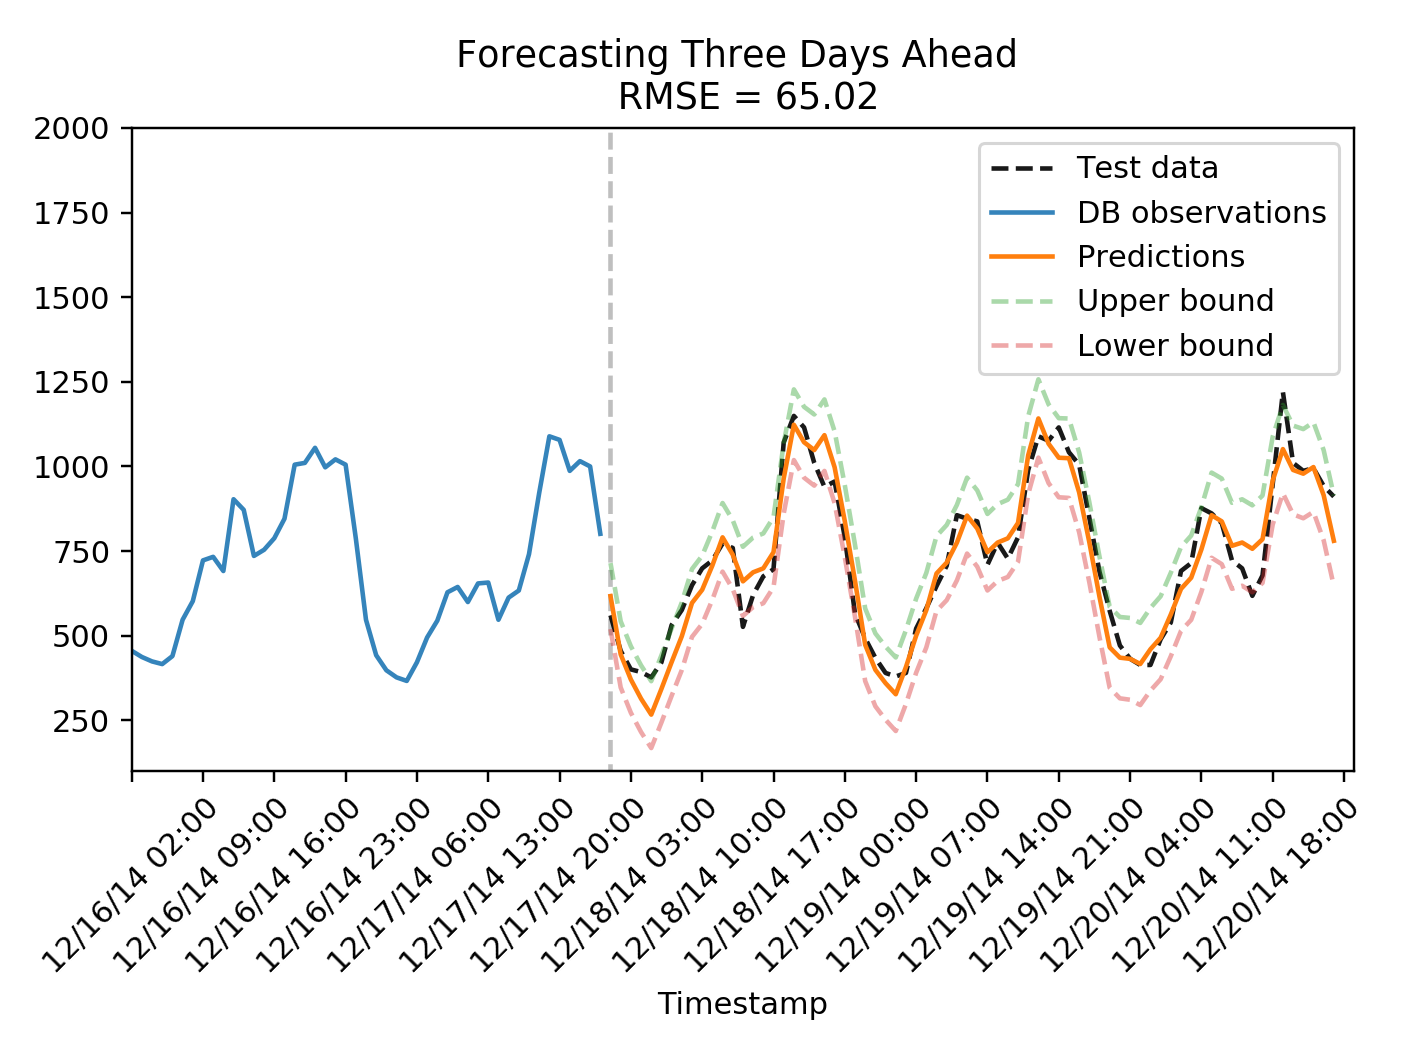

In [17]:

%matplotlib notebook
df_db = pd.read_sql_query("select time::timestamp,h1 from electricity where time > '2014-12-16 01:00:00';", conn)
T = len(df_db)
plt.figure()
predict_range = len(df['prediction'])
plt.plot(np.arange(T,T+predict_range),data_test['h1'],'k--', label = 'Test data', alpha = 0.9)
plt.plot(np.arange(T), df_db['h1'],'-', label = 'DB observations', alpha = 0.9)
plt.plot( np.arange(T,T+predict_range),df['prediction'],'-' ,label = 'Predictions')
plt.plot( np.arange(T,T+predict_range), df['ub'],'--', label = 'Upper bound', alpha = 0.4)
plt.plot( np.arange(T,T+predict_range),df['lb'], '--',label = 'Lower bound', alpha = 0.4)
plt.vlines(T,0,2000, linestyle = 'dashed', color= 'grey', alpha = 0.5)
plt.ylim([100,2000])
plt.xlim([0,5*24])
plt.xlabel('Timestamp')
plt.title('Forecasting Three Days Ahead \n RMSE = %.2f'%(rmse(df['prediction'],data_test['h1'] )))
plt.legend()
T = len(df_db)
predict_range = len(df)
plt.xticks(np.arange(0,T+predict_range+1,7),np.concatenate([df_db['time'].dt.strftime('%m/%d/%y %H:%M'),pd.to_datetime(data_test['time'].values).strftime('%m/%d/%y %H:%M')])[::7], rotation=45)
plt.tight_layout()
plt.show()


Pleasingly, **tspDB** can predict 72 hours (i.e. three days) with reasonable accuracy. (RMSE of 65.02). Not only that, the lower and upper bound seems to capture the variation in the observations where ~ 90% of observations are within the confidence interval.

Note that **tspDB** allows you to be more conservative in your estimate and set a higher confidence interval using the option ` c => `. For example, we can set the confidence interval to 99.5% as follows:


<IPython.core.display.Javascript object>


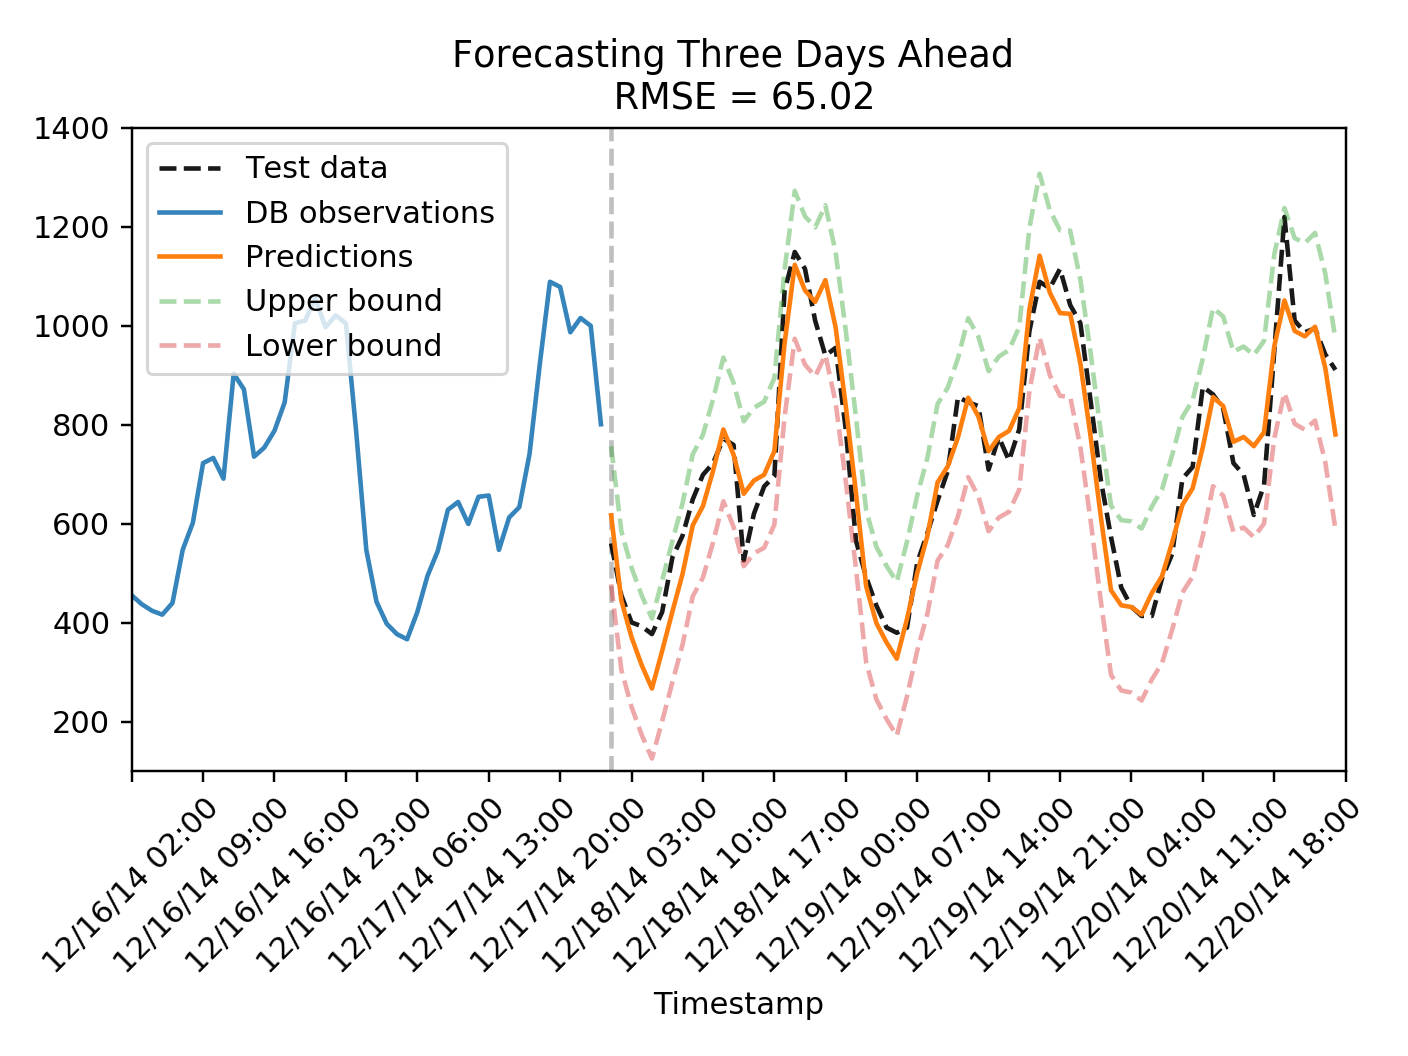

In [19]:
%matplotlib notebook
df = pd.read_sql_query("select * from predict_range('electricity','h1','2014-12-18 01:00:00'::timestamp\
,'2014-12-21  00:00:00'::timestamp,'pindex1', c => 99.5);", conn)

# plot Prediction

plt.figure()
predict_range = len(df['prediction'])
plt.plot(np.arange(T,T+predict_range),data_test['h1'],'k--', label = 'Test data', alpha = 0.9)
plt.plot(np.arange(T), df_db['h1'],'-', label = 'DB observations', alpha = 0.9)
plt.plot( np.arange(T,T+predict_range),df['prediction'],'-' ,label = 'Predictions')
plt.plot( np.arange(T,T+predict_range), df['ub'],'--', label = 'Upper bound', alpha = 0.4)
plt.plot( np.arange(T,T+predict_range),df['lb'], '--',label = 'Lower bound', alpha = 0.4)
plt.vlines(T,0,2000, linestyle = 'dashed', color= 'grey', alpha = 0.5)
plt.ylim([100,1400])
plt.xlim([0,4*24])
plt.xlabel('Timestamp')
plt.title('Forecasting Three Days Ahead \n RMSE = %.2f'%(rmse(df['prediction'],data_test['h1'] )))
plt.legend()
plt.xticks(np.arange(0,T+predict_range+1,7),np.concatenate([df_db['time'].dt.strftime('%m/%d/%y %H:%M'),pd.to_datetime(data_test['time'].values).strftime('%m/%d/%y %H:%M')])[::7], rotation=45)
plt.tight_layout()
plt.show()




The same Process can be repeated for other houses as seen below:


<IPython.core.display.Javascript object>


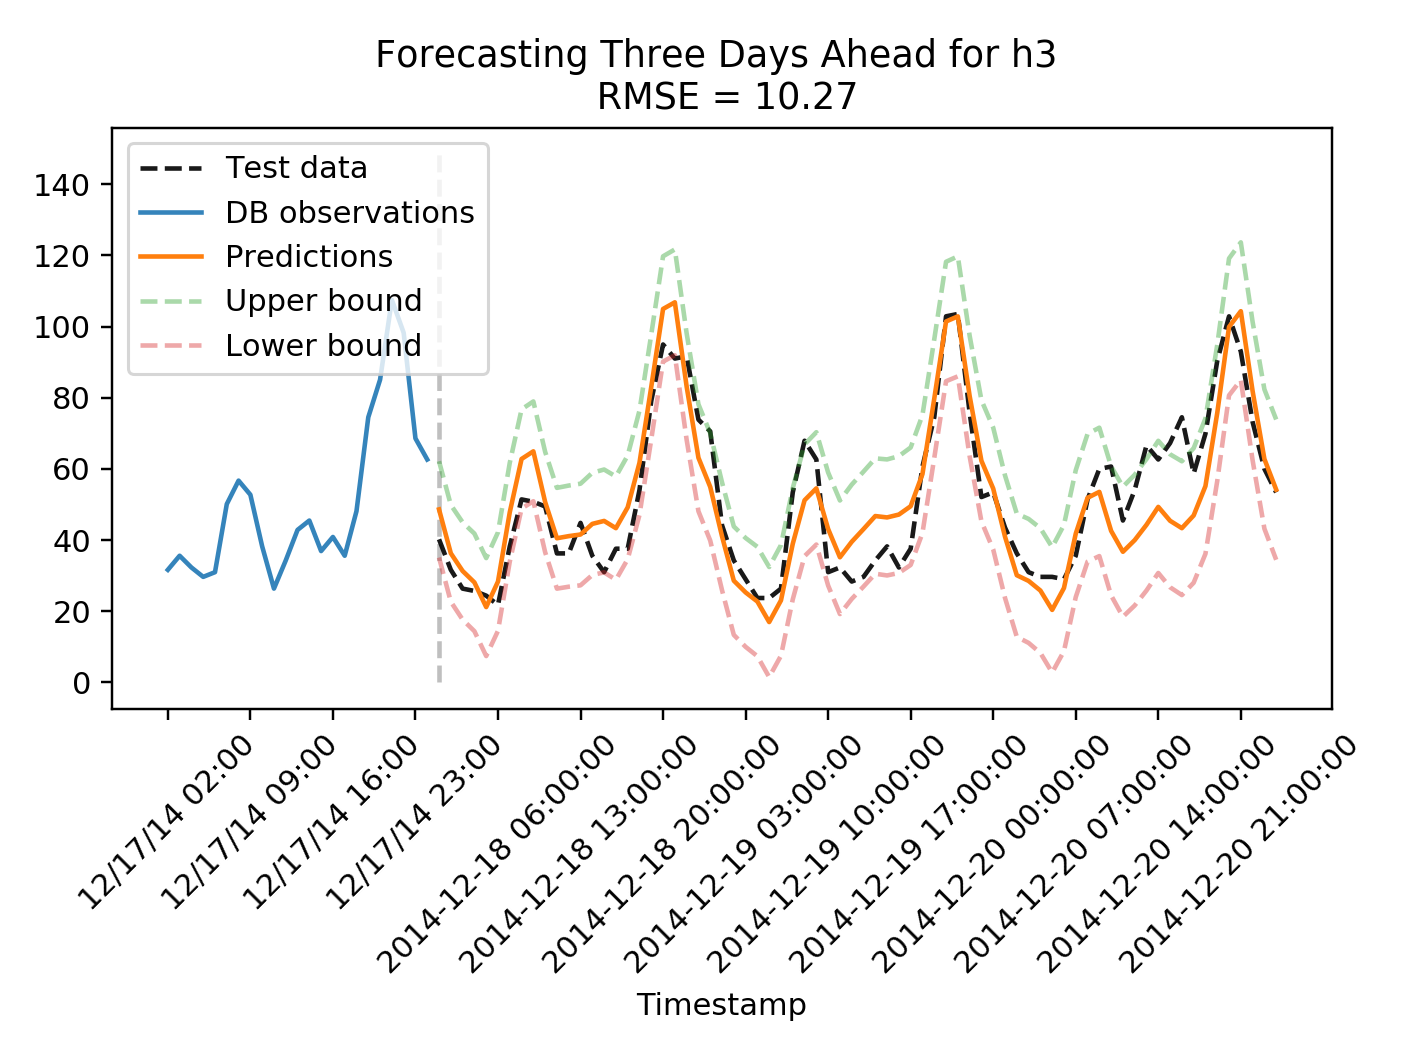

<IPython.core.display.Javascript object>


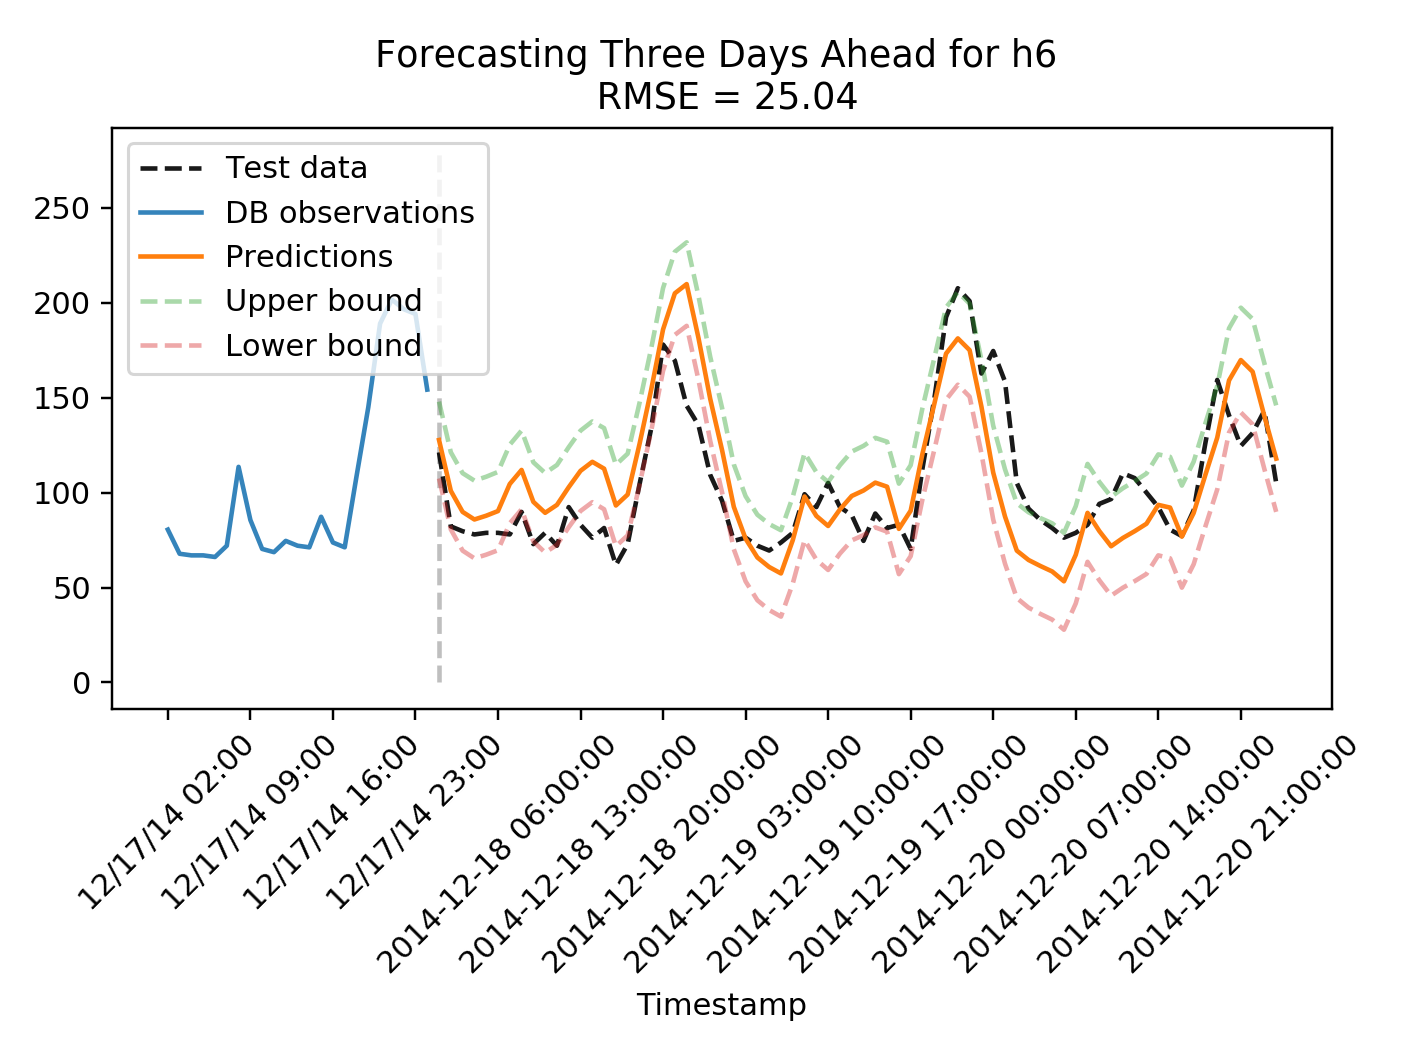

<IPython.core.display.Javascript object>


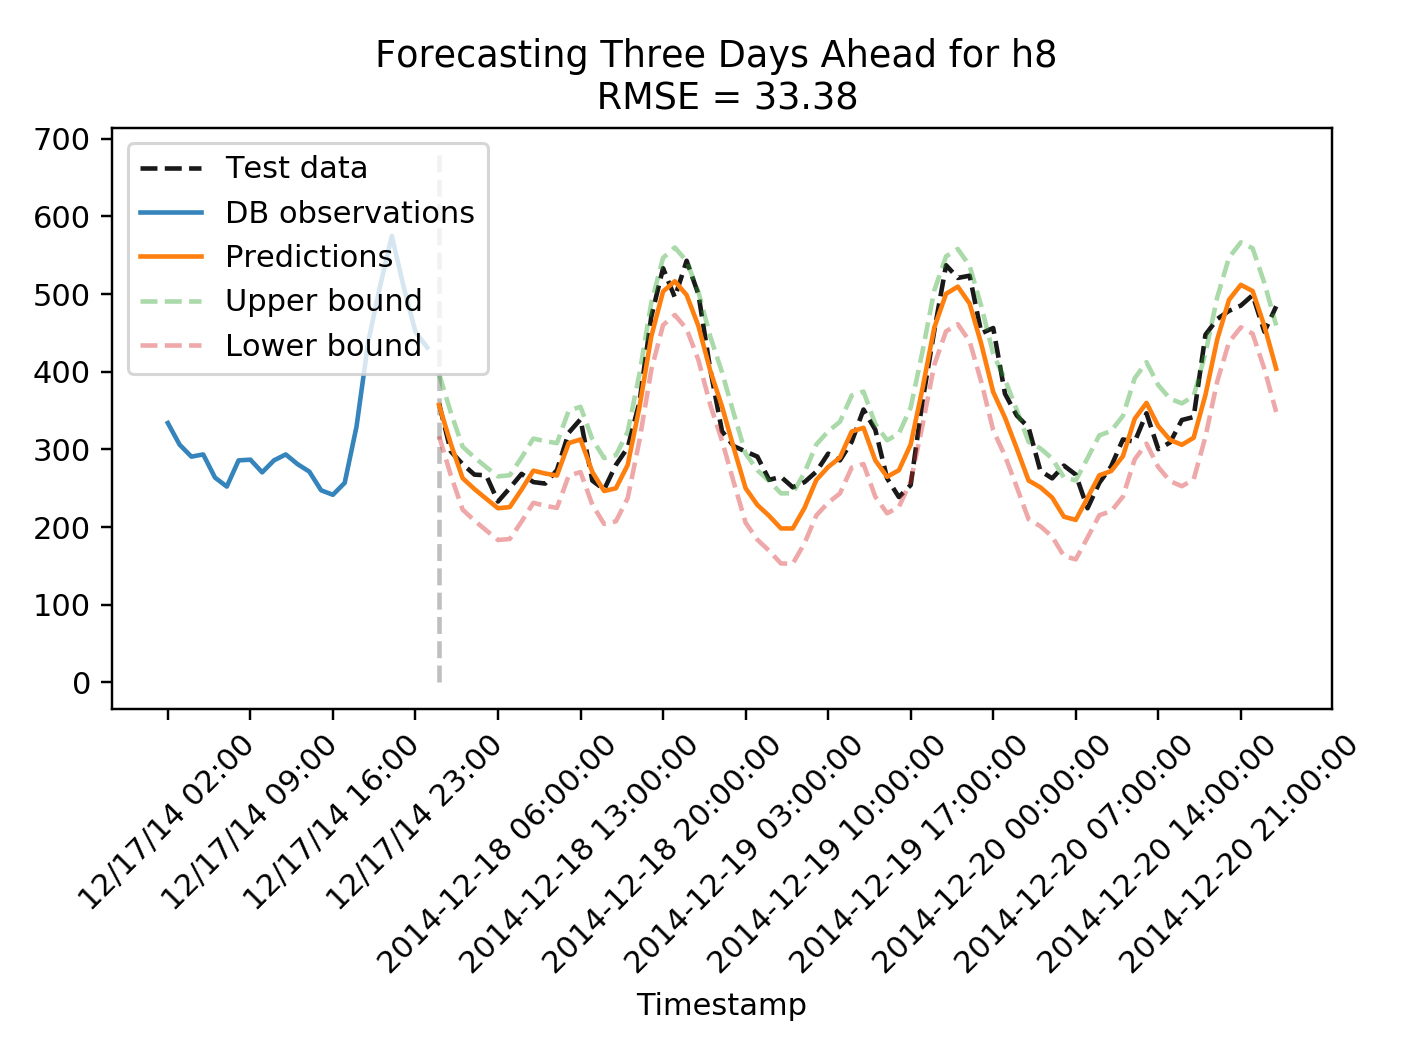

<IPython.core.display.Javascript object>


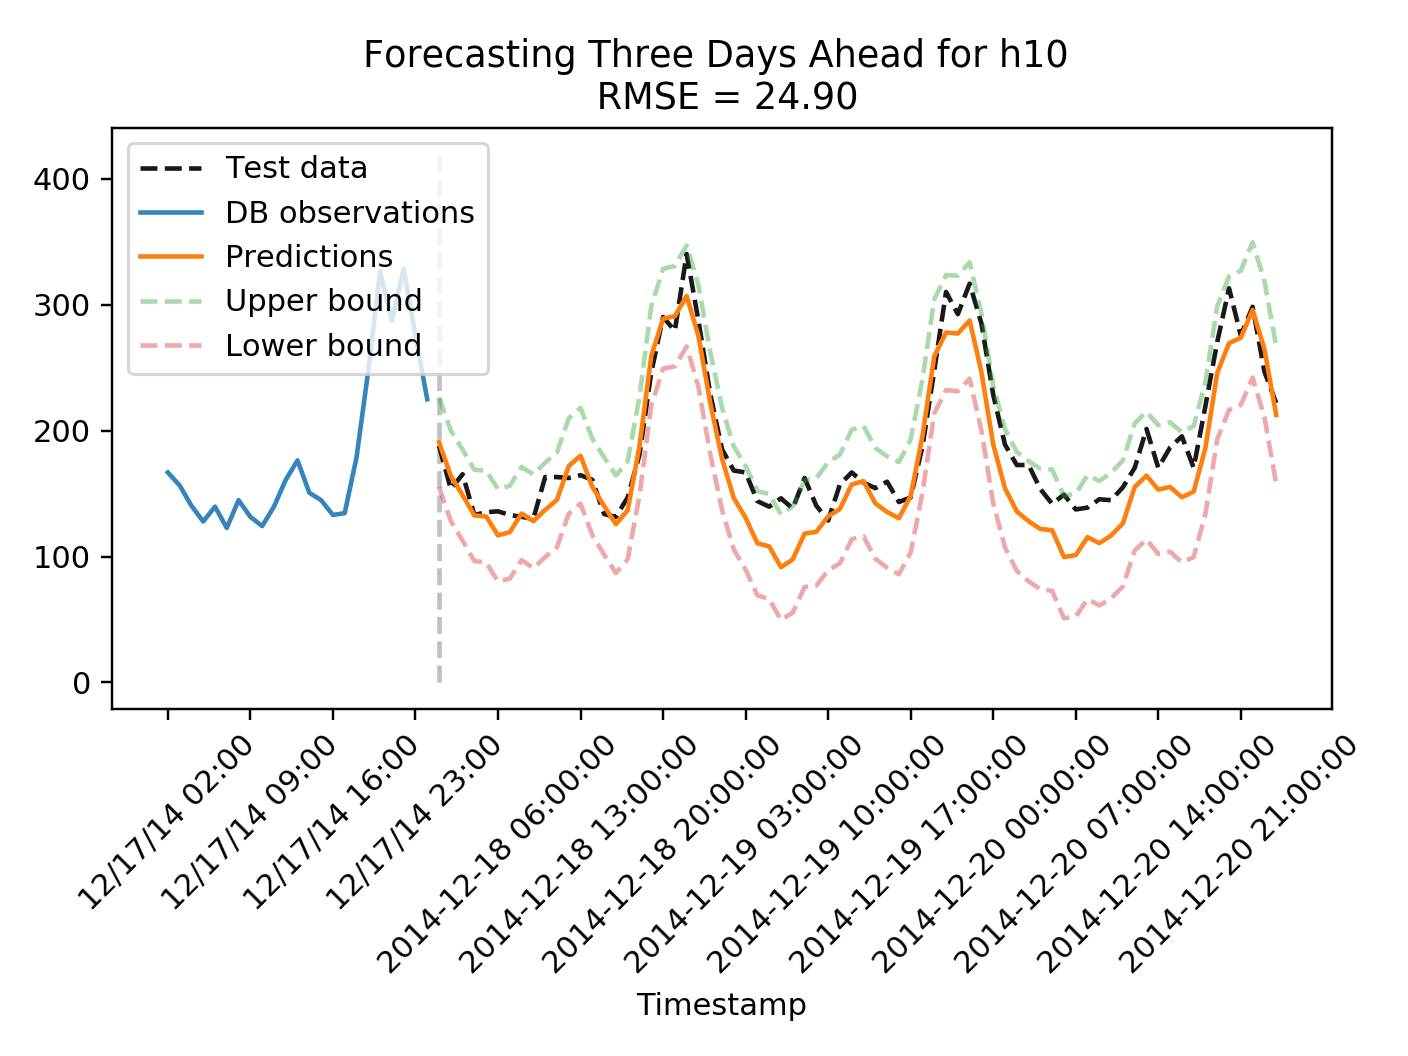

In [21]:
%matplotlib notebook

#plot Prediction
for i in [3,6,8,10]:
    house ='h'+str(i)
    df = pd.read_sql_query("select * from predict_range('electricity','%s','2014-12-18 01:00:00'::timestamp\
,'2014-12-21  00:00:00'::timestamp,'pindex1');"%(house), conn)
    df_db = pd.read_sql_query("select time::timestamp,%s from electricity where time > '2014-12-17 01:00:00';"%(house), conn)
    T = len(df_db)
    plt.figure()
    predict_range = len(df['prediction'])
    plt.plot(np.arange(T,T+predict_range),data_test[house],'k--', label = 'Test data', alpha = 0.9)
    plt.plot(np.arange(T), df_db[house],'-', label = 'DB observations', alpha = 0.9)
    plt.plot( np.arange(T,T+predict_range),df['prediction'],'-' ,label = 'Predictions')
    plt.plot( np.arange(T,T+predict_range), df['ub'],'--', label = 'Upper bound', alpha = 0.4)
    plt.plot( np.arange(T,T+predict_range),df['lb'], '--',label = 'Lower bound', alpha = 0.4)
    plt.vlines(T,0,max(df['ub'])*1.2, linestyle = 'dashed', color= 'grey', alpha = 0.5)
    plt.xlabel('Timestamp')
    plt.title('Forecasting Three Days Ahead for %s \n RMSE = %.2f'%(house, rmse(df['prediction'],data_test[house] )))
    plt.legend()
    plt.xticks(np.arange(0,4*24,7),np.concatenate([df_db['time'].dt.strftime('%m/%d/%y %H:%M'),data_test['time']])[::7], rotation=45)
    plt.tight_layout()
    plt.show()




## Part II: **tspDB's Robustness.** 

In this demonstration, we will show **tspDB's** Robustness against data quality issues that are commonly encountered in time series data. 

### 1. Missing Data
Let's start with the issue of missing data. Using the same electricity data, we will attempt to forecast future values using only 50% of the data. Further, we will impute the missing values. 

Let's start by inspecting the table `electricity_missing`, wherein 50% of the data is missing. 



In [22]:
# lets query our table electricity to inspect the data
conn = psycopg2.connect(conn_string)
df = pd.read_sql_query("select * from electricity_missing order by time DESC limit 10;", conn)
conn.close()
df

time           h1          h2         h3          h4  \
0 2014-12-18 00:00:00   801.047120   90.909091  62.664908         NaN   
1 2014-12-17 23:00:00          NaN  100.249066  68.601583         NaN   
2 2014-12-17 22:00:00          NaN  148.816936  98.284960  259.945130   
3 2014-12-17 21:00:00          NaN  172.478207        NaN  251.714678   
4 2014-12-17 20:00:00  1078.534031  242.839352  85.092348         NaN   
5 2014-12-17 19:00:00  1089.005236         NaN  74.538259         NaN   
6 2014-12-17 18:00:00          NaN  209.215442        NaN  174.211248   
7 2014-12-17 17:00:00          NaN         NaN  35.620053  163.923182   
8 2014-12-17 16:00:00          NaN         NaN  40.897098  163.923182   
9 2014-12-17 15:00:00   612.565445  148.194271        NaN         NaN   

            h5          h6          h7          h8          h9         h10  
0  1042.056075  154.237288  136.419001         NaN         NaN         NaN  
1  1397.196262  194.067797         NaN         NaN         NaN  275.532697  
2          NaN  196.610169         NaN         NaN  515.967439         NaN  
3          NaN  201.694915         NaN  574.590953  537.883532         NaN  
4          NaN         NaN  180.267966  510.105871  614.902943  326.230713  
5  1579.439252  144.915254  161.388551  438.883542         NaN         NaN  
6  1336.448598         NaN         NaN         NaN         NaN         NaN  
7   869.158879         NaN         NaN  256.977863         NaN  134.459956  
8          NaN   73.728814   68.209501         NaN         NaN  132.990448  
9   822.429907   87.288136   66.991474         NaN         NaN  144.746510

We can see that the table is full of `NaN`. Regardless, let's create the prediction index `pindex2` on columns (`h1`, ..., `h10`) in this table, as we did before. 


In [23]:
conn = psycopg2.connect(conn_string)
cursor = conn.cursor()
cursor.execute("""select create_pindex('electricity_missing', 'time','{"h1","h2","h3","h4","h5","h6","h7","h8","h9","h10"}','pindex2');""")
conn.commit()
conn.close()

Now, let's forecast the next three days using `pindex2`, and plot the output as we did in Part I.

<IPython.core.display.Javascript object>


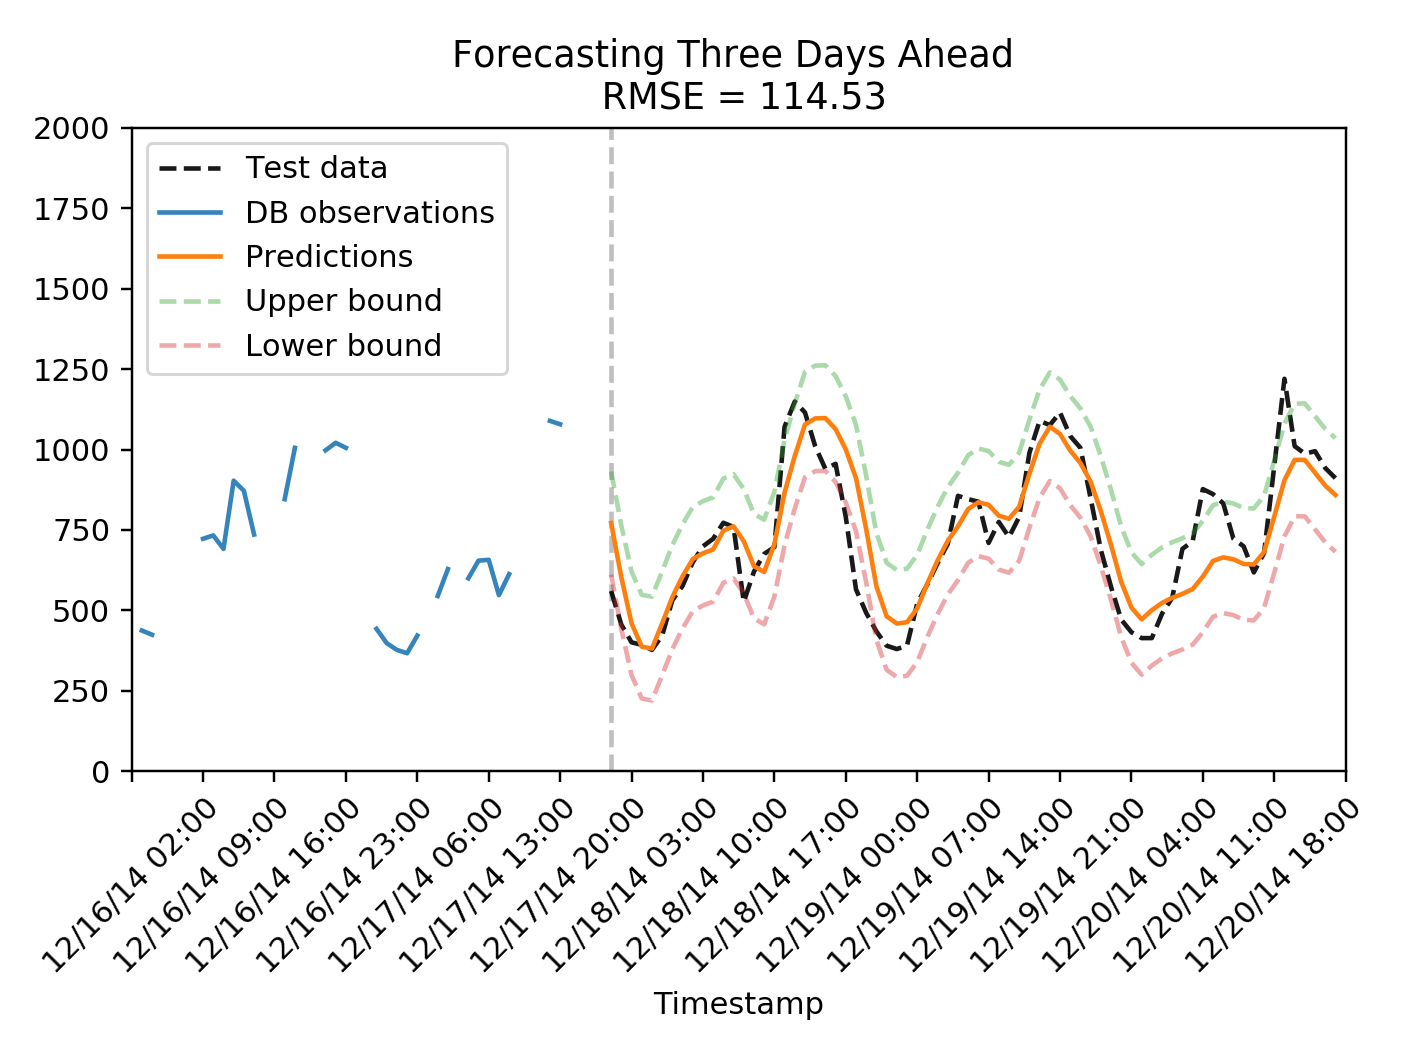

In [24]:
# connect
conn = psycopg2.connect(conn_string)

# Predict
df = pd.read_sql_query("select * from predict_range('electricity_missing','h1','2014-12-18 01:00:00'::timestamp\
,'2014-12-21  00:00:00'::timestamp,'pindex2');", conn)


#plot Prediction
%matplotlib notebook
df_db = pd.read_sql_query("select time::timestamp,h1 from electricity_missing where time > '2014-12-16 01:00:00';", conn)
T = len(df_db)
plt.figure()
predict_range = len(df['prediction'])
plt.plot(np.arange(T,T+predict_range),data_test['h1'],'k--', label = 'Test data', alpha = 0.9)
plt.plot(np.arange(T), df_db['h1'],'-', label = 'DB observations', alpha = 0.9)
plt.plot( np.arange(T,T+predict_range),df['prediction'],'-' ,label = 'Predictions')
plt.plot( np.arange(T,T+predict_range), df['ub'],'--', label = 'Upper bound', alpha = 0.4)
plt.plot( np.arange(T,T+predict_range),df['lb'], '--',label = 'Lower bound', alpha = 0.4)
plt.vlines(T,0,2000, linestyle = 'dashed', color= 'grey', alpha = 0.5)
plt.ylim([0,2000])
plt.xlim([0,4*24])
plt.xlabel('Timestamp')
plt.title('Forecasting Three Days Ahead \n RMSE = %.2f'%(rmse(df['prediction'],data_test['h1'] )))
plt.legend()
plt.xticks(np.arange(0,T+predict_range+1,7),np.concatenate([df_db['time'].dt.strftime('%m/%d/%y %H:%M'),pd.to_datetime(data_test['time'].values).strftime('%m/%d/%y %H:%M')])[::7], rotation=45)
plt.tight_layout()

plt.show()


Pleasingly, even though we only observe 50% of the data, **tspDB's** forecasting performance maintains a decent accuracy. 

Further, **tspDB** allows for recovering these missing values. As an example, we will recover the missing values in the first three days of November 2014. We will compare the recovered values with the true values in table `electricity`.

<IPython.core.display.Javascript object>


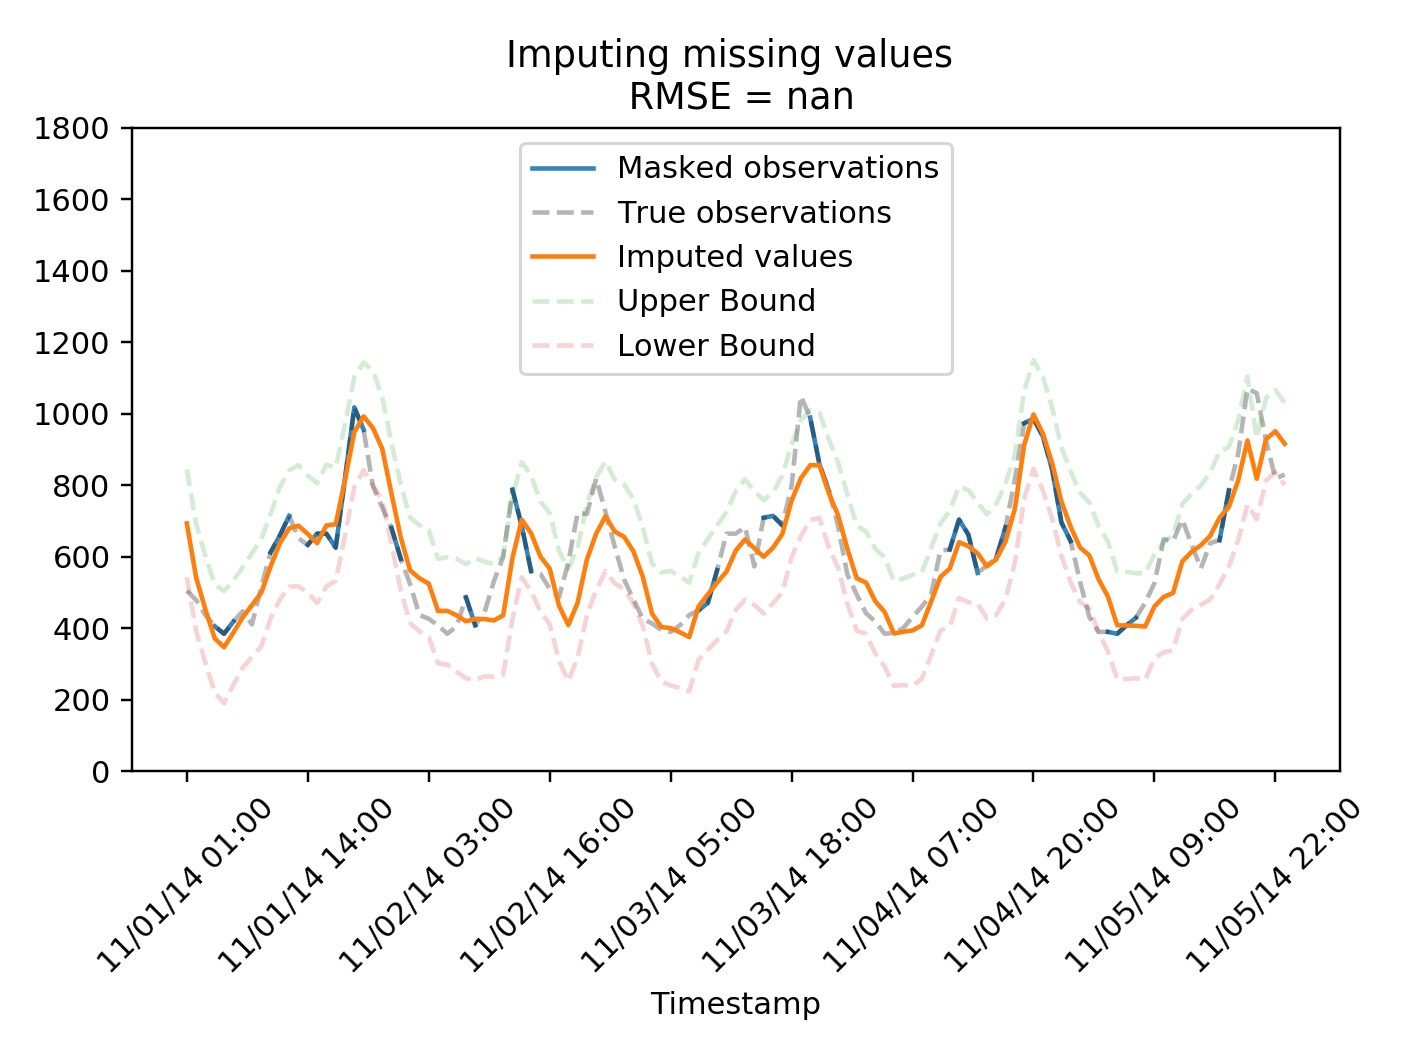

In [28]:
# connect
conn = psycopg2.connect(conn_string)

# Impute missing values
df = pd.read_sql_query("select * from predict_range('electricity_missing','h1','2014-11-01 01:00:00'::timestamp\
,'2014-11-5  23:00:00'::timestamp,'pindex2');", conn)

# get true values
true_values = pd.read_sql_query("select time::timestamp,h1 from electricity where time >= '2014-11-01 01:00:00' and time <= '2014-11-05  23:00:00';", conn)

# also, get missing observation to plot
df_db = pd.read_sql_query("select time::timestamp,h1 from electricity_missing where time >= '2014-11-01 01:00:00' and time <= '2014-11-05  23:00:00';", conn)


#plot Prediction and true observations

T = len(df_db)
plt.figure()
predict_range = len(df['prediction'])
plt.plot(np.arange(T), df_db['h1'],'-', label = 'Masked observations', alpha = 0.9)
plt.plot(np.arange(T), true_values['h1'],'k--', label = 'True observations', alpha = 0.29)
plt.plot( np.arange(T),df['prediction'],'-' ,label = 'Imputed values')
plt.plot( np.arange(T), df['ub'],'--', label = 'Upper Bound', alpha = 0.2)
plt.plot( np.arange(T),df['lb'], '--',label = 'Lower Bound', alpha = 0.2)
plt.ylim([0,1800])
# plt.xlim([0,4*24])
plt.xlabel('Timestamp')
plt.title('Imputing missing values \n RMSE = %.2f'%(rmse(df['prediction'][np.isnan(df_db1['h1'])],df_db['h1'][np.isnan(df_db1['h1'])] )))
plt.legend()
plt.xticks(np.arange(0,T,13),df_db['time'].dt.strftime('%m/%d/%y %H:%M')[::13], rotation=45)
plt.tight_layout()
plt.show()



### 2. Noisy Data
Using a *noisier* version of the electricity data, we will attempt to forecast future values in a similar manner. 

A noisier version of the data is in the table `electricity_noisy`. Similar to what we've done before, we will create a prediction index on the table.


In [29]:
conn = psycopg2.connect(conn_string)
cursor = conn.cursor()
cursor.execute("""select create_pindex('electricity_noisy', 'time','{"h1","h2","h3","h4","h5","h6","h7","h8","h9","h10"}','pindex3');""")
conn.commit()
conn.close()

Now, we will visually inspect the quality of the predictions.

<IPython.core.display.Javascript object>


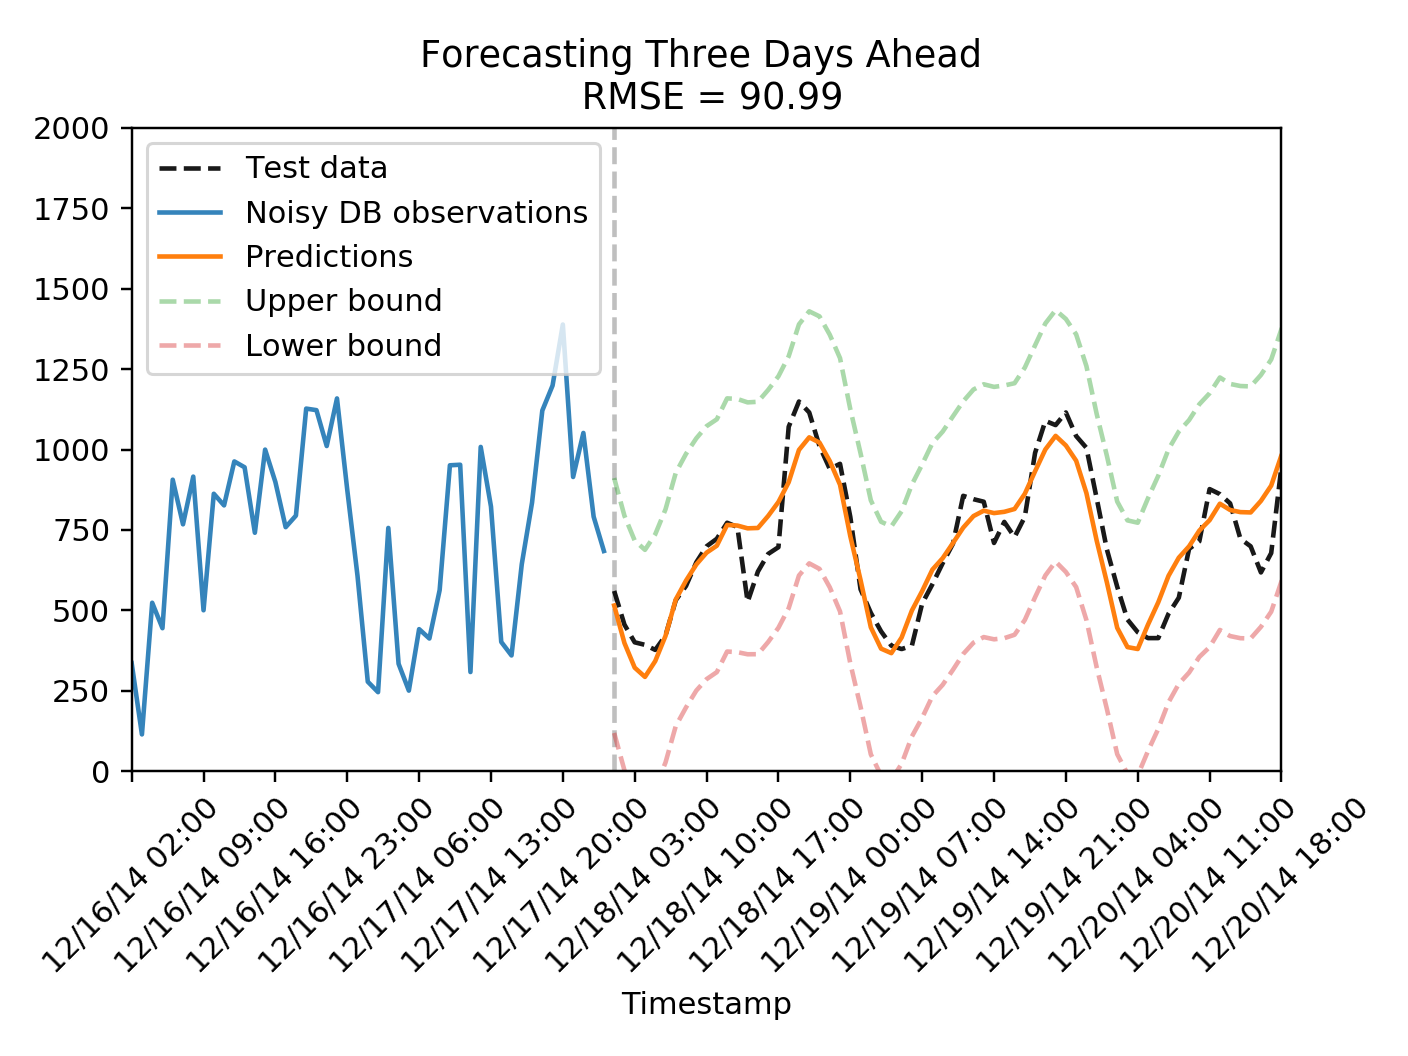

In [30]:
# connect
conn = psycopg2.connect(conn_string)

# Predict
df = pd.read_sql_query("select * from predict_range('electricity_noisy','h1','2014-12-18 01:00:00'::timestamp\
,'2014-12-21  00:00:00'::timestamp,'pindex3');", conn)


#plot Prediction
%matplotlib notebook
df_db = pd.read_sql_query("select time::timestamp,h1 from electricity_noisy where time > '2014-12-16 01:00:00';", conn)
df_db1 = pd.read_sql_query("select time::timestamp,h1 from electricity where time > '2014-12-16 01:00:00';", conn)

T = len(df_db)
plt.figure()
predict_range = len(df['prediction'])
plt.plot(np.arange(T,T+predict_range),data_test['h1'],'k--', label = 'Test data', alpha = 0.9)
plt.plot(np.arange(T), df_db['h1'],'-', label = 'Noisy DB observations', alpha = 0.9)
#plt.plot(np.arange(T), df_db1['h1'],'-', label = 'Noiseless Observations', alpha = 0.9)
plt.plot( np.arange(T,T+predict_range),df['prediction'],'-' ,label = 'Predictions')
plt.plot( np.arange(T,T+predict_range), df['ub'],'--', label = 'Upper bound', alpha = 0.4)
plt.plot( np.arange(T,T+predict_range),df['lb'], '--',label = 'Lower bound', alpha = 0.4)
plt.vlines(T,0,2000, linestyle = 'dashed', color= 'grey', alpha = 0.5)
plt.ylim([0,2000])
plt.xlim([0,4*24])
plt.xlabel('Timestamp')
plt.title('Forecasting Three Days Ahead \n RMSE = %.2f'%(rmse(df['prediction'],data_test['h1'] )))
plt.legend()
plt.xticks(np.arange(0,T+predict_range,7),np.concatenate([df_db['time'].dt.strftime('%m/%d/%y %H:%M'),pd.to_datetime(data_test['time'].values).strftime('%m/%d/%y %H:%M')])[::7], rotation=45)
plt.tight_layout()
plt.show()




**The Results above are pleasing in two ways:**
1. The accuracy of the forecast is still good. In fact, it is similar to the base case when we did not add noise.
2. The estimate for the confidence interval has widened, i.e., the prediction index estimates that there should be less certainty in the observations compared to the noiseless case. Which is what we expect with more noise. 

### 3. Different Noise Models

Now, we will demonstrate the model's robustness against different observation (i.e. noise) models. Specifically, instead of assuming a gaussian model, let's assume the following two cases:
1. Our observations are **Integers** produced by a **Poisson** process, where each observation follows a Poisson distribution with a time-varying mean which we will denote by $f(t)$
2. Our observations are **Boolean** produced by a **Bernoulli** process, where each observation follows a Bernoulli distribution with a time-varying mean which we will denote by $f(t)$

These cases can happen in real-world scenarios. For example, the number of products sold in retail is integer-valued. However, we will restrict our experiments here on the scenario where the underlying mean is known. To do this, we generated a sum of harmonics to play the role of the mean $f(t)$.

The Poisson (i.e. integer) observations (there are 999,000 observations) are in `synthetic_pois`, and Bernoulli (i.e. boolean) observations are in the table `synthetic_ber`. Let's visually inspect these two sets of observations:


<IPython.core.display.Javascript object>


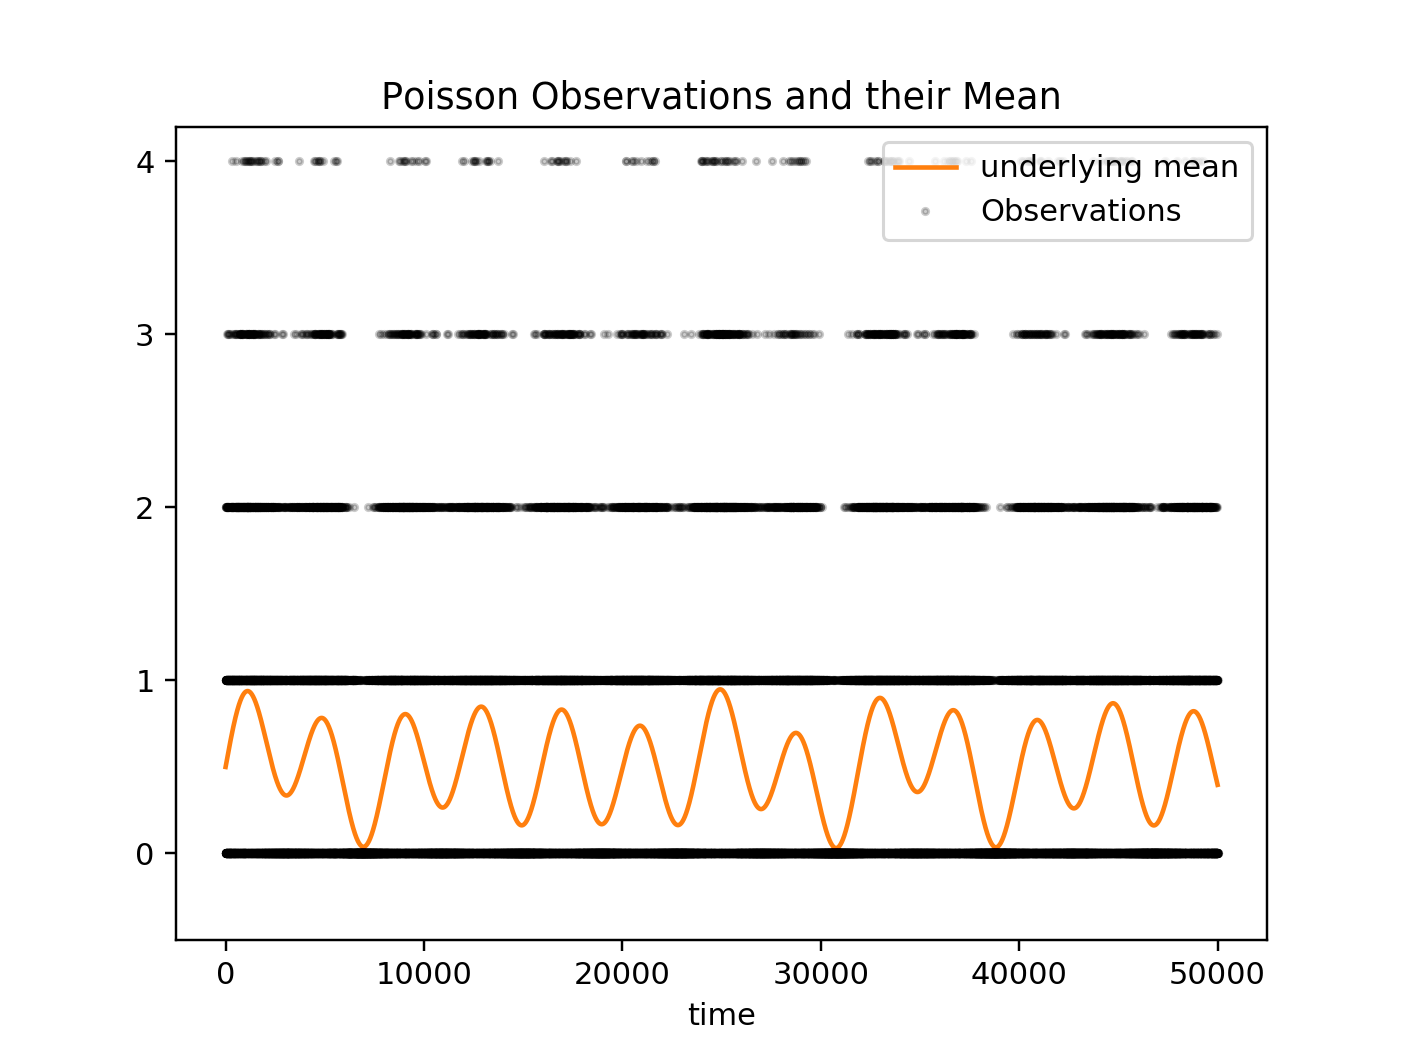

<IPython.core.display.Javascript object>


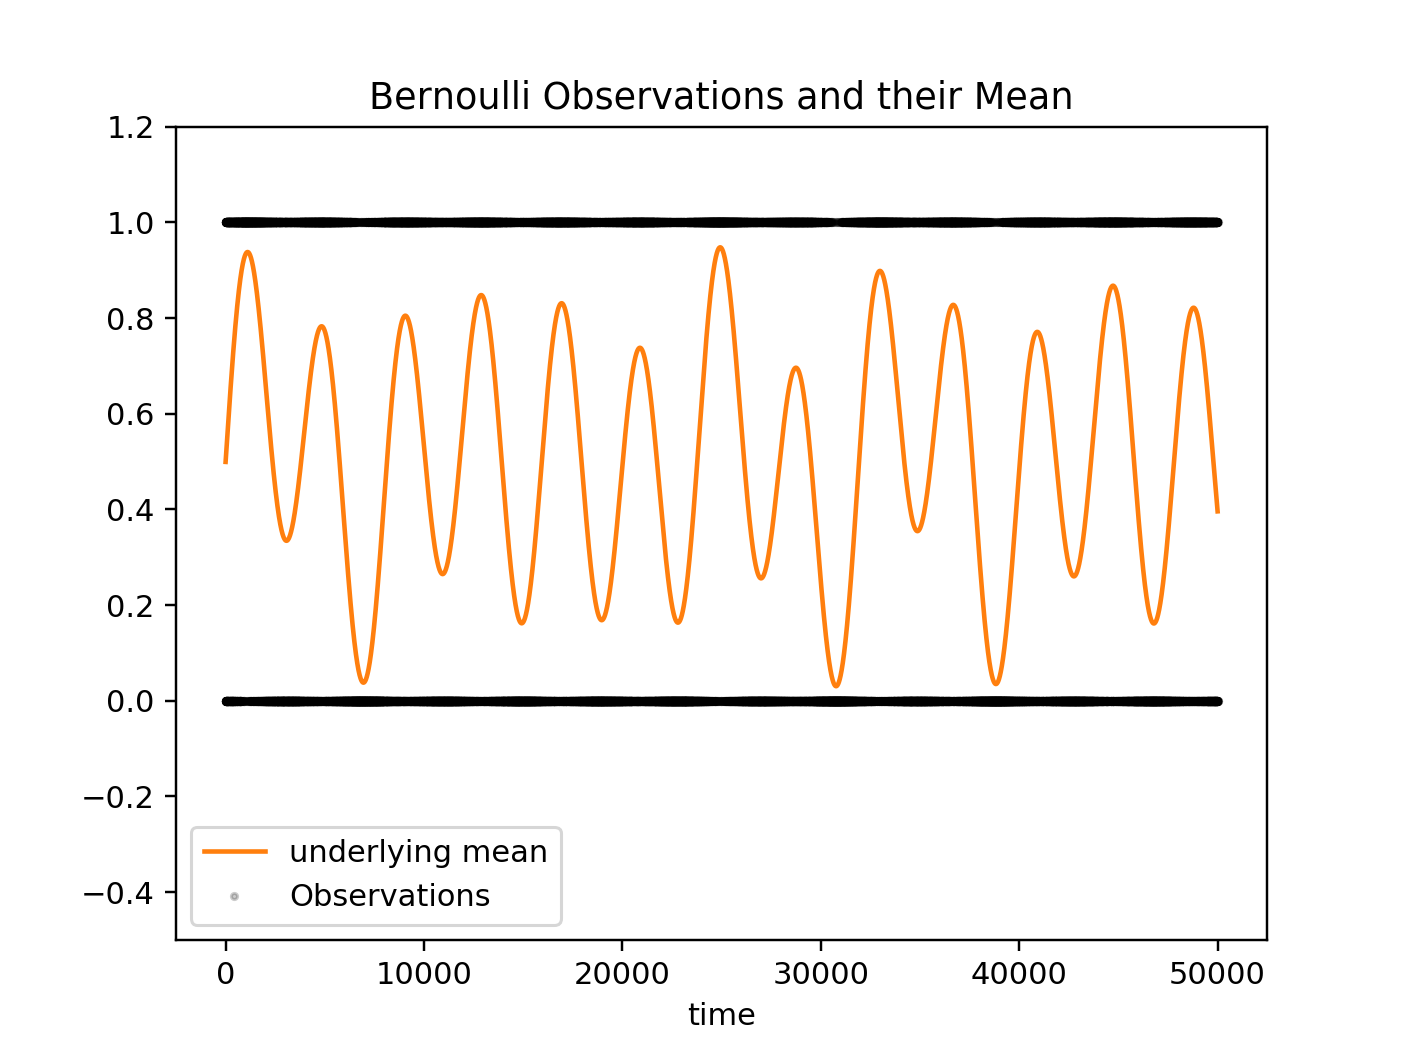

(-0.5, 1.2)

In [31]:
# connect
conn = psycopg2.connect(conn_string)

#plot Prediction
%matplotlib notebook
df_pois = pd.read_sql_query("select means,ts from synthetic_pois where time < 50000 ;", conn)
df_ber = pd.read_sql_query("select means,ts from synthetic_ber where time < 50000 ;", conn)

plt.figure()
plt.title('Poisson Observations and their Mean')
plt.plot( df_pois['means'][:50000], 'tab:orange', label = 'underlying mean')
plt.plot(df_pois['ts'][:50000],'ok',alpha = 0.2, markersize = 2, label = 'Observations')
plt.xlabel('time')
plt.legend()
plt.ylim([-0.5,4.2])


plt.figure()
plt.title('Bernoulli Observations and their Mean')
plt.plot( df_ber['means'][:50000], 'tab:orange', label = 'underlying mean')
plt.plot(df_ber['ts'][:50000],'ok',alpha = 0.2, markersize = 2, label = 'Observations')
plt.xlabel('time')
plt.legend()
plt.ylim([-0.5,1.2])
plt.show()



Now let's see if we can recover (i.e. impute) the underlying mean from these integer/boolean observations. Just like before, we will create a prediction index on each table.

In [42]:
conn = psycopg2.connect(conn_string)
cursor = conn.cursor()
cursor.execute("""select create_pindex('synthetic_pois', 'time','{"ts"}','pindex_pois',  col_to_row_ratio=>1);""")
conn.commit()
conn.close()

conn = psycopg2.connect(conn_string)
cursor = conn.cursor()
cursor.execute("""select create_pindex('synthetic_ber', 'time','{"ts"}','pindex_ber',  col_to_row_ratio=>1);""")
conn.commit()
conn.close()

Note that the prediction index does not use the underlying means, it is only stored in the same DB for convenience.
Let's now try to recover (i.e. impute) the underlying mean time series from time 990,000 to 999,000.

<IPython.core.display.Javascript object>


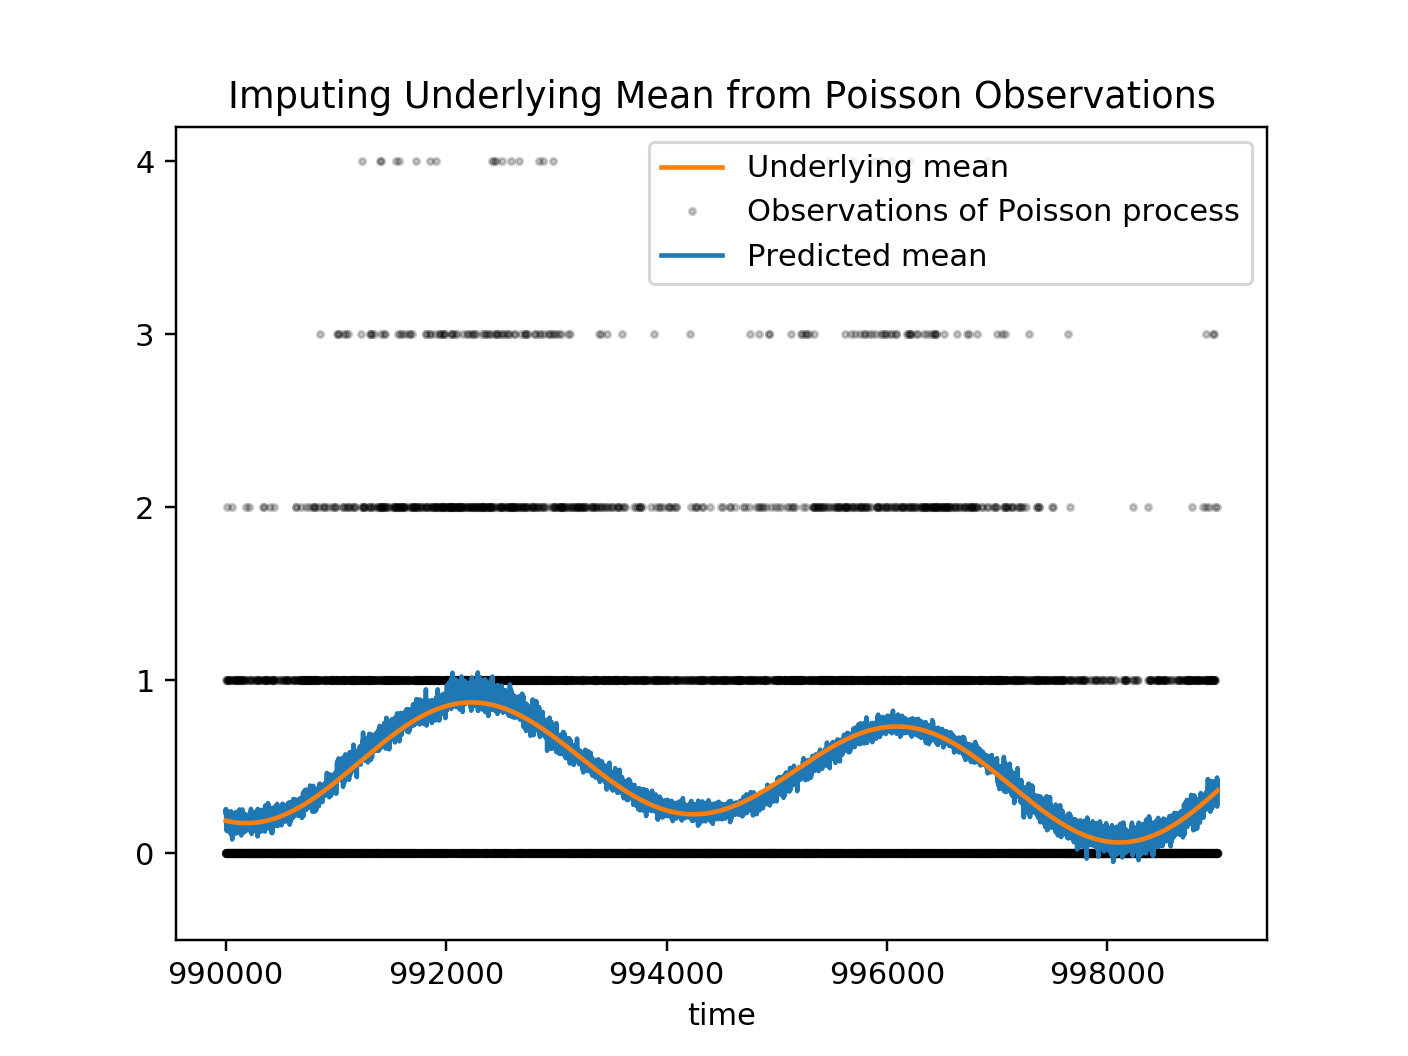

<IPython.core.display.Javascript object>


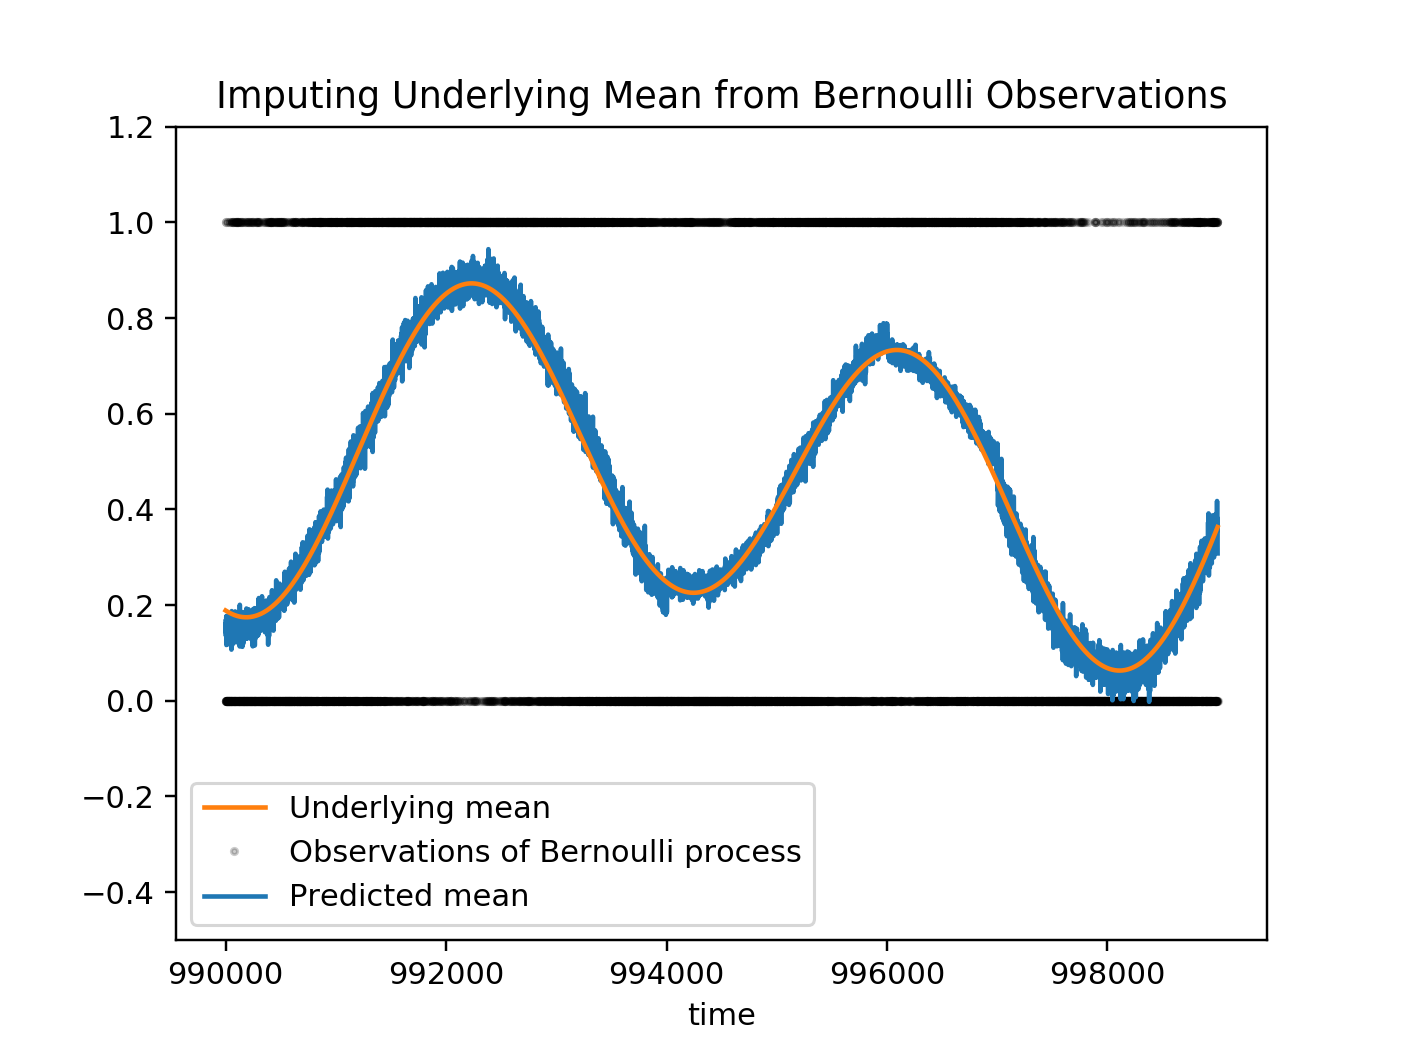

In [32]:
# connect
conn = psycopg2.connect(conn_string)

# Predict for both Bernoulli and Poisson
df_ber_p = pd.read_sql_query("select * from predict_range('synthetic_ber','ts',990000\
,999000-1,'pindex_ber');", conn)

df_pois_p = pd.read_sql_query("select * from predict_range('synthetic_pois','ts',990000\
,999000-1,'pindex_pois');", conn)

df_test = pd.read_csv('data/synthetic_test.csv', sep ='\t')

#plot Prediction
%matplotlib notebook
df_pois = pd.read_sql_query("select means,ts from synthetic_pois ;", conn)
df_ber = pd.read_sql_query("select means,ts from synthetic_ber ;", conn)

plt.figure()
train = 999000
ra = 9000
forecast_range = 0
plt.title('Imputing Underlying Mean from Poisson Observations')
plt.plot(np.arange(train-ra,train+forecast_range), np.concatenate([df_pois['means'],df_test['means']])[train-ra:train+forecast_range], 'tab:orange', label = 'Underlying mean', zorder = 4)
plt.plot(np.arange(train-ra,train),df_pois['ts'][train-ra:train],'ok',alpha = 0.2, markersize = 2, label = 'Observations of Poisson process')
plt.xlabel('t')
plt.plot(np.arange(train-ra,train+forecast_range),df_pois_p['prediction'],label = 'Predicted mean')
# plt.vlines(train,-0.5,3.5, linestyles='dashed')
plt.xlabel('time')
plt.legend()
plt.ylim([-0.5,4.2])


plt.figure()
plt.title('Imputing Underlying Mean from Bernoulli Observations')
plt.plot(np.arange(train-ra,train+forecast_range), np.concatenate([df_ber['means'],df_test['means']])[train-ra:train+forecast_range], 'tab:orange', label = 'Underlying mean', zorder = 4)
plt.plot(np.arange(train-ra,train),df_ber['ts'][train-ra:train],'ok',alpha = 0.2, markersize = 2, label = 'Observations of Bernoulli process')
plt.xlabel('t')
plt.plot(np.arange(train-ra,train+forecast_range),df_ber_p['prediction'],label = 'Predicted mean')
# plt.vlines(train,-0.5,3.5, linestyles='dashed')
plt.xlabel('time')
plt.legend()
plt.ylim([-0.5,1.2])
plt.show()



Note that **tspDB** successfully impute the underlying mean even with these unusual noise model.

## Part III: tspDB's Uncertainity Quantification Capabilities.

Here, we showcase **tspDB's** ability to estimate the underlying variance from highly noisy observations. 

Table `synthetic_var` contains gaussian observations with a time-varying mean (synthetically generated by a sum of harmonics) and a time-varying variance (Also synthetically generated by a sum of harmonics). The underlying mean and variance are included in the table for convenience. 

Specifically, our time series data consist of 4 columns, namely:

**1. `time`**: (int) this column represents the time index as integers

**2. `ts`:** (float) Where the observation of the time series are stored

**3. `means`:** (float) Where the underlying mean of the time series is stored. Note that since this data is synthetically generated, we know what is the underlying mean of the generation process


**4. `var`:** (float) Where the underlying time-varying variance of our time series is stored


Let's take a look at the few last entries in the table: 

In [33]:
conn = psycopg2.connect(conn_string)
df = pd.read_sql_query("select * from synthetic_var order by time DESC limit 10;", conn)
conn.close()
df

time        ts     means       var
0  998999  0.885135  0.905010  0.122488
1  998998  0.845429  0.905045  0.122468
2  998997  1.151417  0.905079  0.122449
3  998996  1.088256  0.905114  0.122430
4  998995  0.875478  0.905149  0.122410
5  998994  1.395005  0.905184  0.122391
6  998993  1.386438  0.905218  0.122372
7  998992  0.672902  0.905253  0.122353
8  998991  0.981625  0.905288  0.122333
9  998990  1.059042  0.905323  0.122314

As done before, we will create a prediction index `pindex_var`  on the column `ts`:

In [34]:
conn = psycopg2.connect(conn_string)
cursor = conn.cursor()
cursor.execute("""select create_pindex('synthetic_var', 'time','{"ts"}','pindex_var');""")
conn.commit()
conn.close()

Now we will get **tspDB's** estimate of both the mean and variance. Since **tspDB** is using Gaussian approximation for estimating the confidence interval, the interval width when the 95% confidence interval equals ~$1.96 \cdot \sigma$, where $ \sigma$ is the standard deviation. We will use this to estimate the variance. 

<IPython.core.display.Javascript object>


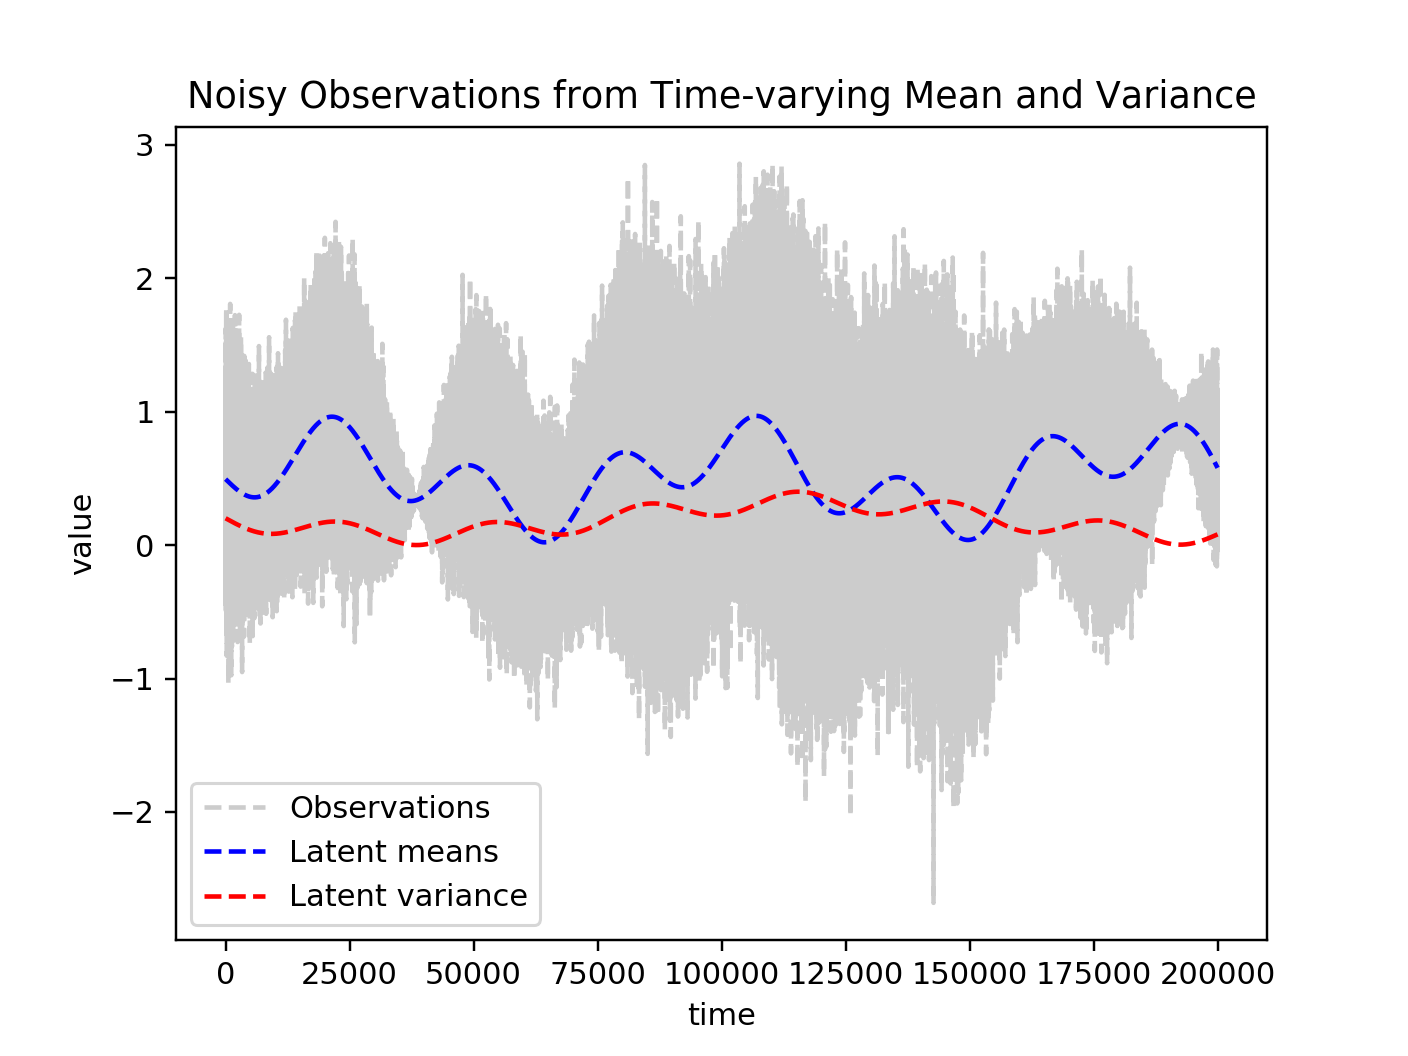

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


<IPython.core.display.Javascript object>


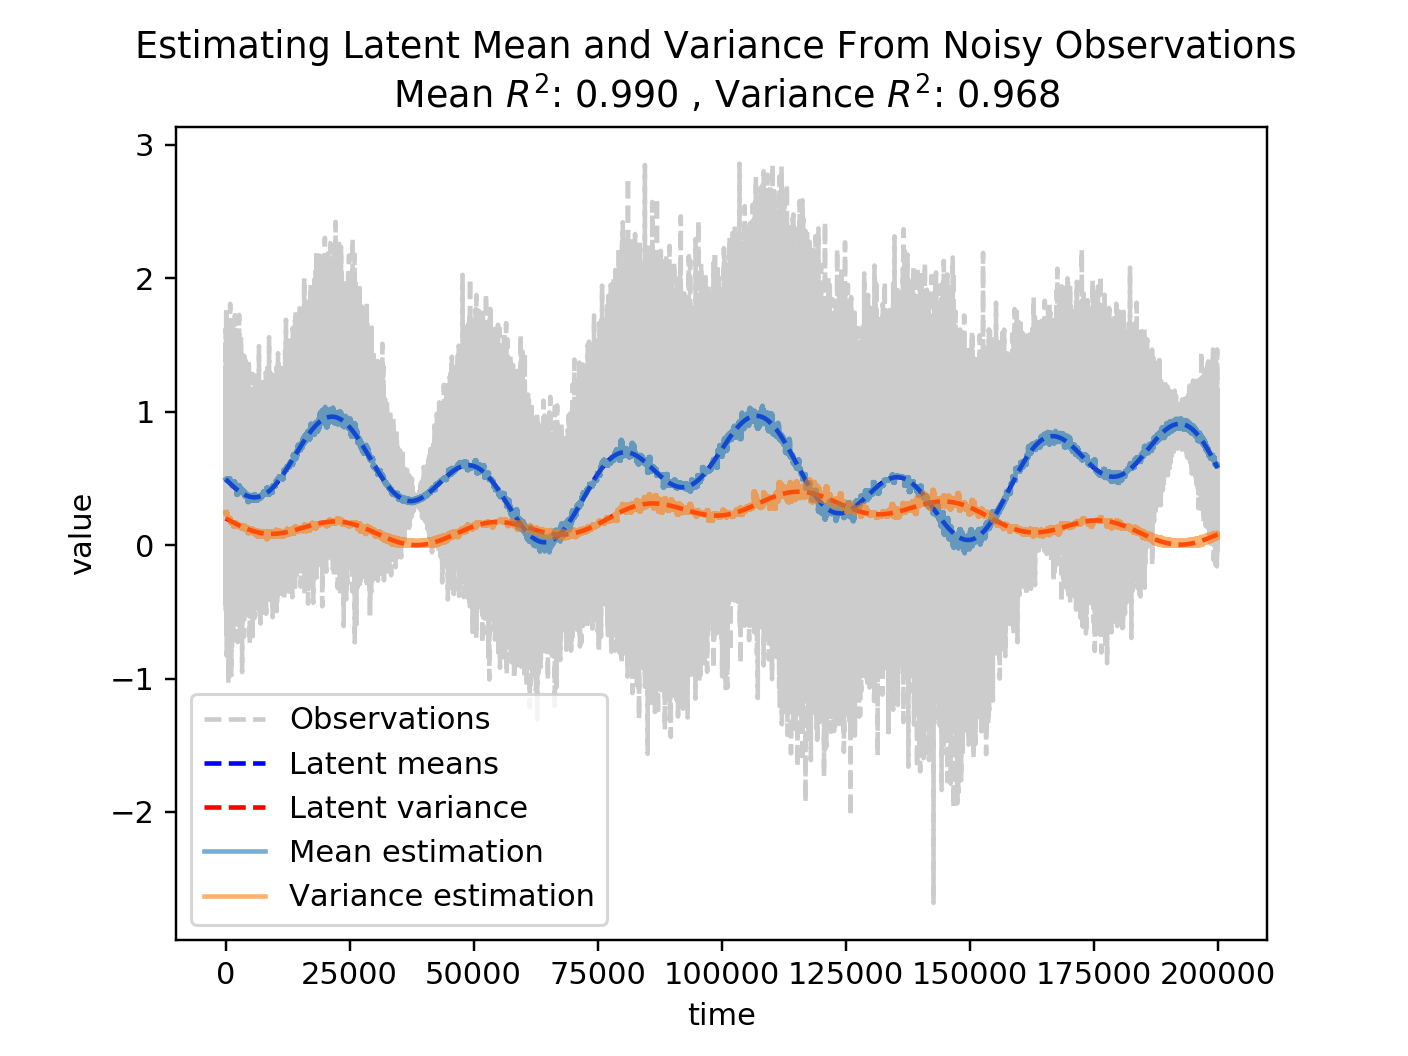

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


In [35]:
conn = psycopg2.connect(conn_string)
%matplotlib notebook
N = 200000
query = "select * from  predict_range('synthetic_var','ts',0,%s,'pindex_var');"%(N-1)
df = pd.read_sql_query(query, conn)
query = "select * from synthetic_var where time >= 0 and time <= %s;"%(N-1)
db_df = pd.read_sql_query(query, conn)

est_var = ((df['prediction'] - df['lb'])/norm.ppf(0.975))**2


plt.figure()
plt.title('Estimating Latent Mean')
plt.plot(db_df['time'], db_df['ts'],'--k', label = 'Observations', alpha = 0.2)
plt.plot( db_df['means'][:N],'--b', label = 'Latent means', alpha = 1.0)
plt.plot(db_df['time'], db_df['var'][:N],'--r', label = 'Latent variance')
plt.ylabel('value')
plt.xlabel('time')
plt.title('Noisy Observations from Time-varying Mean and Variance')
plt.legend()

plt.figure()
plt.plot(db_df['time'], db_df['ts'],'--k', label = 'Observations', alpha = 0.2)
plt.plot( db_df['means'][:N],'--b', label = 'Latent means', alpha = 1.0)
plt.plot(db_df['time'], db_df['var'][:N],'--r', label = 'Latent variance')
plt.plot(df['prediction'], label = 'Mean estimation',alpha = 0.6 )
plt.plot(db_df['time'], est_var, label = 'Variance estimation', alpha = 0.6)
plt.ylabel('value')
plt.xlabel('time')
plt.title('Estimating Latent Mean and Variance From Noisy Observations \n Mean $R^2$: %.3f , Variance $R^2$: %.3f'%(r2_score(db_df['means'][:N], df['prediction'] ),r2_score(db_df['var'][:N],est_var)))
plt.legend()
plt.show()

The figure above shows that even though **tspDB** is unaware of the underlying dynamics of mean and variance, it sucessfully recover them with high $R^2$ score from  very noisy observations (shown in grey). 

## Part IV: System Performance

### 1- Prediction queries latency

Now, we will measure the latency of the proposed predictive queries. Specifically, we will compare their latency with the latency of a standard `SELECT` query. We will use the table `synthetic_var` in this demo.

In [43]:

# Prepare connection
conn = psycopg2.connect(conn_string)
cursor = conn.cursor()

# Number of tests
N = 50
T = 999000*np.random.random(N).astype(int)
cursor.execute("select predict('synthetic_var','ts',0,'pindex_var')")

# Measure SELECT latency
t_ = time.time()
for i in T:
    cursor.execute("select ts from synthetic_var where time =%s"%(i))
select_latency = (time.time() - t_)/len(T)

# Measure Predict Impute latency
t_ = time.time()
for i in T:
    cursor.execute("select  predict('synthetic_var','ts',%s,'pindex_var', uq => false)"%(i))
predict_imp_latency = (time.time() - t_)/len(T)

# Measure Predict Forecast latency
t_ = time.time()
for i in T:
    cursor.execute("select  predict('synthetic_var','ts',999000,'pindex_var', uq => false)")
pedict_forecast_query = (time.time() - t_)/len(T)

select_latency,predict_imp_latency,pedict_forecast_query


(0.0004392814636230469, 0.0015918779373168945, 0.002985820770263672)

<IPython.core.display.Javascript object>


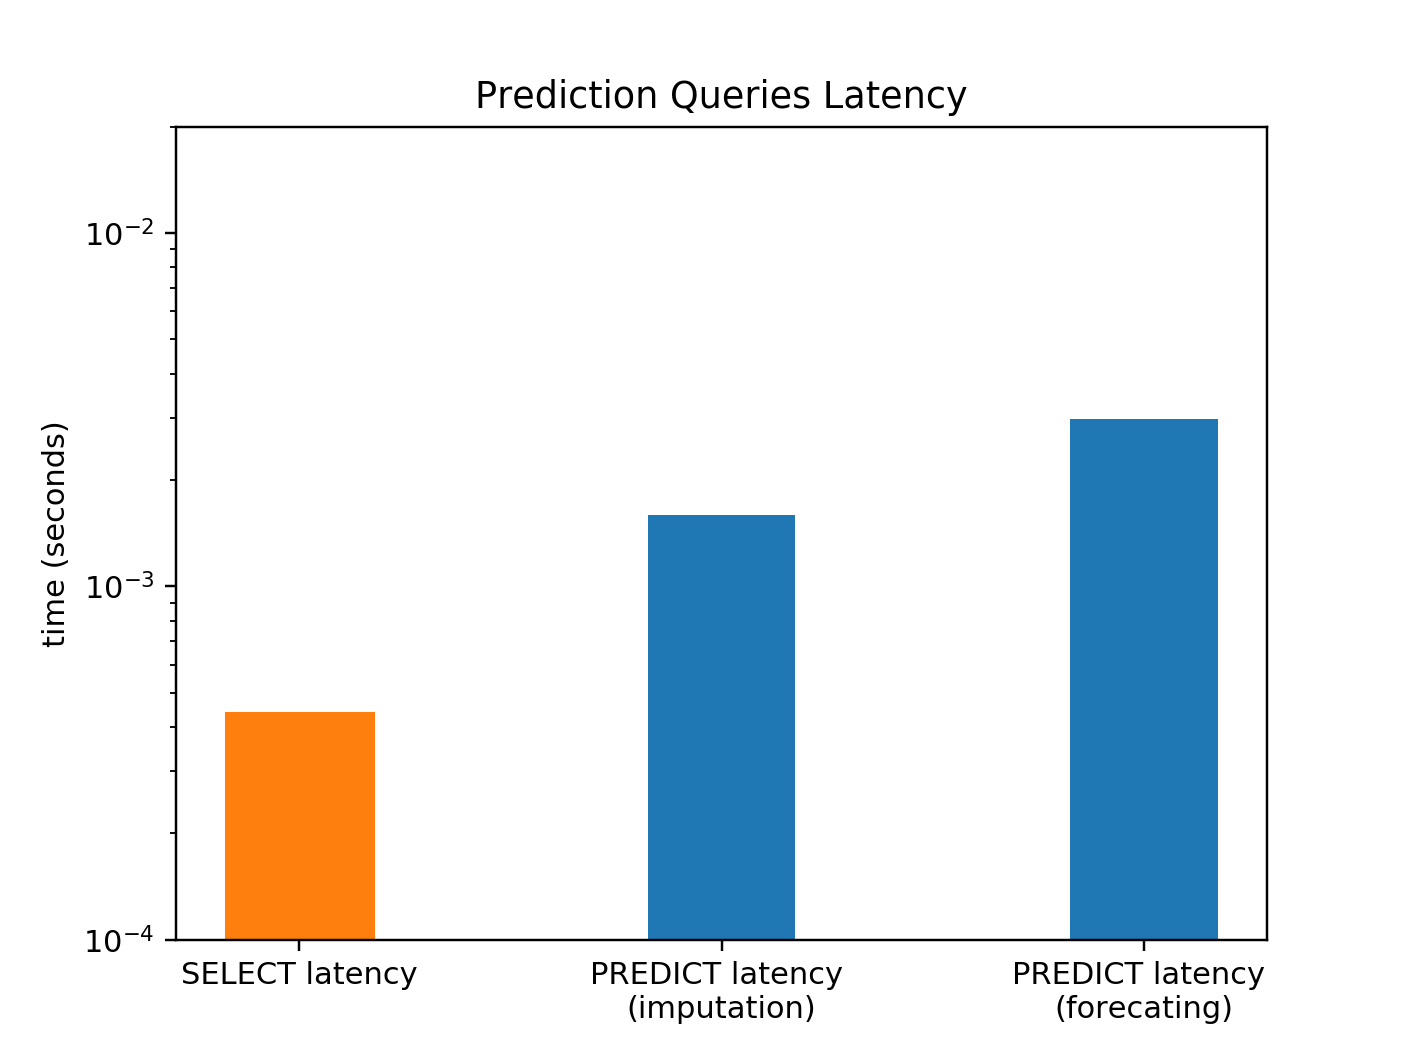

In [44]:
# Plot

cm = 1
N = 3
fig, ax = plt.subplots()
ind = np.arange(3)   
width = .350         
p1 = ax.bar(ind, [select_latency,predict_imp_latency,pedict_forecast_query], width, bottom=0*cm)

ax.set_title('Prediction Queries Latency')
ax.set_xticks(ind)
ax.set_xticklabels(['SELECT latency','PREDICT latency \n(imputation)','PREDICT latency \n(forecating)'])
plt.ylabel('time (seconds)')
ax.autoscale_view()
ax.set_yscale('log')
plt.ylim(0.0001,0.02)

p1[0].set_color('tab:orange')
plt.show()

We can see from the figure above that the proposed predictive queries are of similar latency to a standard `SELECT` queries. In particular, an imputation query takes around 1 millisecond, while a forecasting query takes only 4 milliseconds.

### 2- Insert throughput

In this part, we will measure the time taken to build a prediction index. Specifically, we will show that creating a prediction index takes less time than inserting into a PostgreSQL table using the bulk insert command `COPY`. 

In [45]:
# Prepare Connection 
conn = psycopg2.connect(conn_string)
cursor = conn.cursor()
cursor.execute("""select create_pindex('electricity', 'time','{"h1"}','pindex_test');""")

def bulk_insert(df, table_name, conn_string):
    conn = psycopg2.connect(conn_string)
    cur = conn.cursor()
    output = io.StringIO()
    df.to_csv(output, sep='\t', header=False, index=False)
    output.seek(0)
    cur.copy_from(output,table_name, null="")
    conn.commit()
    conn.close()


In [46]:
# Load Tables
electricity = pd.read_csv('data/electricity.csv', sep = '\t')
synth = pd.read_csv('data/synthetic_var.csv', sep = '\t').iloc[:,:2]

#Insert time into Postgres

## Electricity
# Drop and create table
cursor.execute("DROP table IF EXISTS electricity_test;")
conn.commit()
electricity.head(0).to_sql('electricity_test', engine, index=False)
# Bulk Insert
t = time.time()
bulk_insert(electricity, 'electricity_test', conn_string)
postgres_elec_insert_time = time.time()-t
## Synthetic
# Drop and create table
cursor.execute("DROP table IF EXISTS synthetic_var_test;")
conn.commit()
synth.head(0).to_sql('synthetic_var_test', engine, index=False)
# Time Bulk Insert
t = time.time()
bulk_insert(synth, 'synthetic_var_test', conn_string)
postgres_synth_insert_time = time.time()-t

# Prediction index insert time
t = time.time()
cursor.execute("""select create_pindex('electricity', 'time','{"h1"}','pindex_test');""")
pindex_elec_insert_time = time.time()-t

t = time.time()
cursor.execute("""select create_pindex('synthetic_var', 'time','{"ts"}','pindex_test');""")
pindex_synth_insert_time = time.time()-t


<IPython.core.display.Javascript object>


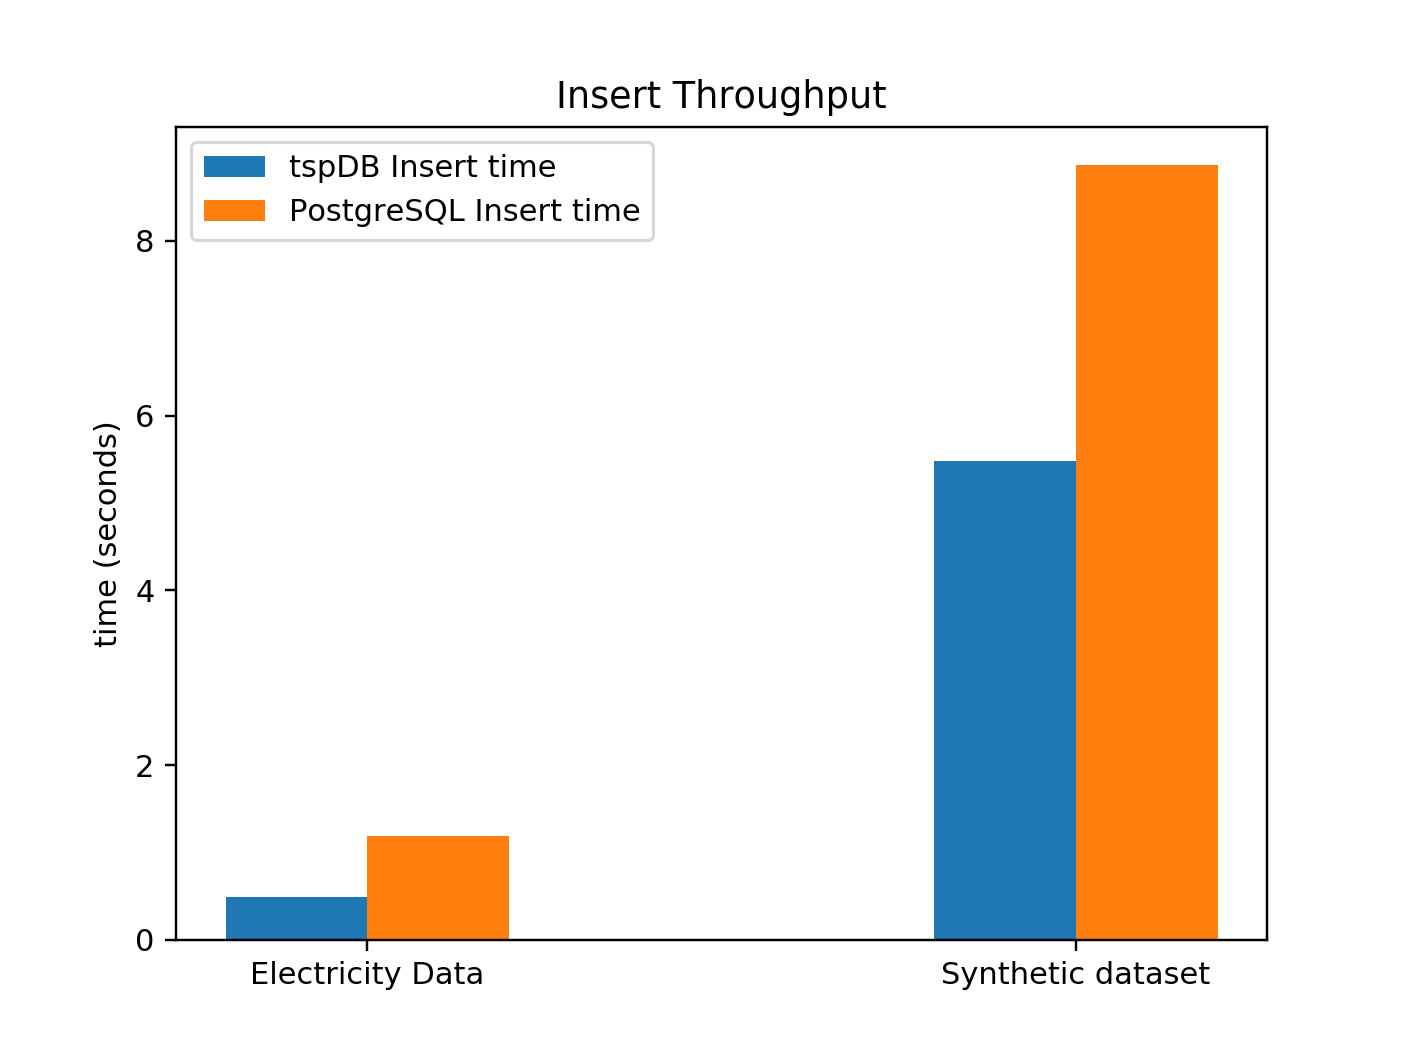

In [47]:
cm = 1
N = 3
fig, ax = plt.subplots()
ind = np.arange(2)   
width = .2         
p1 = ax.bar(ind-0.1, [pindex_elec_insert_time, pindex_synth_insert_time], width, bottom=0*cm)
p2 = ax.bar(ind+0.1, [postgres_elec_insert_time, postgres_synth_insert_time], width, bottom=0*cm)
ax.legend((p1,p2),('tspDB Insert time', 'PostgreSQL Insert time'))

ax.set_title('Insert Throughput')
ax.set_xticks(ind)
ax.set_xticklabels(['Electricity Data','Synthetic dataset'])
plt.ylabel('time (seconds)')
ax.autoscale_view()
plt.show()


The results above show that creating a single-column prediction index is indeed faster than inserting into a PostgreSQL table. Hence, the added computational overhead should not be a bottleneck in the system performance. 

# Conclusion

**In this demonstration, we showed tspDB's robust and efficient predictive capabilities. We showed that it is indeed possible to build a system that integrates predictive capabilities and is:**
1. **Computationally performant:** the system has high insert throughput and thus does not compromise the DB system performance, and its predictive queries are of latency comparable to `SELECT` point queries.  
2. **Statistically accurate:** the system predictions are accurate even with data quality issues common in time series such as missing values and highly noisy observations.
